# FEDOT framework
#### FEDOT version = 0.7.0

In [ ]:
pip install fedot==0.7.0

In [4]:
import logging
# set DEBUG for everything
logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger('matplotlib')
# set WARNING for Matplotlib
logger.setLevel(logging.WARNING)

Below is a description of the FEDOT framework and its main functions, which can be used to solve various ML tasks, namely:

* Regression
* Classification
* Time series forecasting
* Clustering

FEDOT can construct complex composite models (consisting of multiple machine learning models and preprocessing operations) based on an evolutionary algorithm. Thus, it is possible to create pipelines for solving various tasks.

The structure of the FEDOT framework can be seen in the figure below:

<img src="../jupyter_media/fedot_structure/fedot_structure_04.png" width="800"/> 

Figure 1. The structure of the FEDOT framework. The main modules of the library are shown.

As you can see from the picture there are two ways to start FEDOT:
1) API - allows you to run framework models in a few lines of code;
2) Low-level methods from the core - you can call methods by accessing the core directly. In this case, you will have to write more code, but more functionality opens up.

## Composite models

FEDOT has following abstractions:
* Operation - is a machine learning model or preprocessing operation or statistical models;
* Node - is a container in which the operation is placed. A single node can contain only one operation;
* Pipeline - is directed acyclic graph-like structure that contains several connected nodes. The analogue can be a computation graph from tensorflow, or simple workflow (from Apache Airflow, for instance). Pipelines are complex composite models. A single pipeline can consist of multiple nodes, or a single node.

<img src="../jupyter_media/fedot_structure/operation_node_pipeline.png" width="800"/> 

## Generate synthetic dataset for classification task

In [5]:
import logging
logging.raiseExceptions = False

from fedot.utilities.synth_dataset_generator import classification_dataset
from sklearn.metrics import roc_auc_score as roc_auc

# Generate numpy arrays with features and target
features_options = {'informative': 1, 'redundant': 0,
                    'repeated': 0, 'clusters_per_class': 1}
x_data, y_data = classification_dataset(samples_amount=250,
                                        features_amount=3,
                                        classes_amount=2,
                                        features_options=features_options)

print(f'Features table shape: {x_data.shape}, type: {type(x_data)}')
print(f'Target vector: {y_data.shape}, type: {type(y_data)}')

Features table shape: (250, 3), type: <class 'numpy.ndarray'>
Target vector: (250,), type: <class 'numpy.ndarray'>


Prepare the necessary imports

In [6]:
import numpy as np

# Create pipelines
from fedot.core.pipelines.pipeline import Pipeline
from fedot.core.pipelines.node import PrimaryNode, SecondaryNode

# Tasks to solve
from fedot.core.repository.tasks import Task, TaskTypesEnum

# Dataclass for wrapping arrays into it
from fedot.core.data.data import InputData

# Type of the input data
from fedot.core.repository.dataset_types import DataTypesEnum

# Define classification task
task = Task(TaskTypesEnum.classification)

# Prepare data to train the model
input_data = InputData(idx=np.arange(0, len(x_data)), features=x_data,
                       target=y_data, task=task,
                       data_type=DataTypesEnum.table)

## Manual pipeline 

Below, we will try to set the pipeline manually, and obtain a prediction using it.

Manually create a pipeline with the following configuration:

![logit_scaling_lda.png](../jupyter_media/fedot_structure/logit_scaling_lda.png)

In [7]:
# Define pipeline 
node_logit = PrimaryNode('logit')
node_scaling = PrimaryNode('scaling')
node_logit = SecondaryNode('lda', nodes_from=[node_logit, node_scaling])
pipeline = Pipeline(node_logit)

# Fit it
pipeline.fit(input_data)

# Make prediction
predicted_output = pipeline.predict(input_data)
probs = np.array(predicted_output.predict)

# Check metric value
print(f'ROC AUC score on training sample: {roc_auc(y_data, probs):.3f}')

c:\users\valery\appdata\local\programs\python\python38\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ROC AUC score on training sample: 0.955


This is how you learned the concept of pipelines in FEDOT.

But FEDOT can automatically construct such pipelines to solve the task.

Below are two examples for solving the classification task (with such pipelines) using API methods and using FEDOT.core function directly. Both examples, regardless of the way they interact, run an automatic machine learning algorithm.

## AutoML

### API example

Using the API allows you to find good solutions using a few lines of code, but on the other hand, this approach has less abilities for modification than using core-based methods.

In [8]:
from fedot.api.main import Fedot

# Task selection, initialisation of the framework
fedot_model = Fedot(problem='classification', 
                    timeout=1, preset='fast_train',
                    seed=20, logging_level=0)

# During fit, the pipeline composition algorithm is started
pipeline = fedot_model.fit(features=x_data,
                           target=y_data)

INFO:root:AssumptionsHandler - Initial pipeline fitting started


2023-03-10 17:07:48,596 - AssumptionsHandler - Initial pipeline fitting started


INFO:root:AssumptionsHandler - Initial pipeline was fitted successfully


2023-03-10 17:07:48,927 - AssumptionsHandler - Initial pipeline was fitted successfully


Level 45:root:AssumptionsHandler - Memory consumption for fitting of the initial pipeline in main session: current 0.3 MiB, max: 1.0 MiB


2023-03-10 17:07:48,930 - AssumptionsHandler - Memory consumption for fitting of the initial pipeline in main session: current 0.3 MiB, max: 1.0 MiB


CRITICAL:root:ApiComposer - Initial pipeline was fitted in 0.3 sec.


2023-03-10 17:07:48,932 - ApiComposer - Initial pipeline was fitted in 0.3 sec.


CRITICAL:root:ApiComposer - AutoML configured. Parameters tuning: True. Time limit: 1 min. Set of candidate models: ['qda', 'logit', 'bernb', 'normalization', 'knn', 'pca', 'dt', 'rf', 'scaling', 'qda', 'logit', 'bernb', 'normalization', 'knn', 'pca', 'dt', 'rf', 'scaling'].


2023-03-10 17:07:48,937 - ApiComposer - AutoML configured. Parameters tuning: True. Time limit: 1 min. Set of candidate models: ['qda', 'logit', 'bernb', 'normalization', 'knn', 'pca', 'dt', 'rf', 'scaling', 'qda', 'logit', 'bernb', 'normalization', 'knn', 'pca', 'dt', 'rf', 'scaling'].


CRITICAL:root:ApiComposer - Pipeline composition started.


2023-03-10 17:07:48,943 - ApiComposer - Pipeline composition started.


INFO:root:DataSourceSplitter - K-folds cross validation is applied.


2023-03-10 17:07:48,945 - DataSourceSplitter - K-folds cross validation is applied.


Generations:   0%|                                                                          | 1/10000 [00:00<?, ?gen/s]INFO:root:MultiprocessingDispatcher - Number of used CPU's: 12


2023-03-10 17:07:48,950 - MultiprocessingDispatcher - Number of used CPU's: 12


CRITICAL:root:MultiprocessingDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.


2023-03-10 17:07:54,596 - MultiprocessingDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 1 size: 1


2023-03-10 17:07:54,599 - EvoGraphOptimizer - Generation num: 1 size: 1


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<ClassificationMetricsEnum.ROCAUC_penalty=-0.929 ComplexityMetricsEnum.node_num=0.200>']


2023-03-10 17:07:54,601 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<ClassificationMetricsEnum.ROCAUC_penalty=-0.929 ComplexityMetricsEnum.node_num=0.200>']


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 12


2023-03-10 17:07:55,589 - MultiprocessingDispatcher - Number of used CPU's: 12


CRITICAL:root:MultiprocessingDispatcher - 21 individuals out of 21 in previous population were evaluated successfully.


2023-03-10 17:08:04,889 - MultiprocessingDispatcher - 21 individuals out of 21 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 2 size: 21


2023-03-10 17:08:04,892 - EvoGraphOptimizer - Generation num: 2 size: 21


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<ClassificationMetricsEnum.ROCAUC_penalty=-0.954 ComplexityMetricsEnum.node_num=0.200>']


2023-03-10 17:08:04,895 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<ClassificationMetricsEnum.ROCAUC_penalty=-0.954 ComplexityMetricsEnum.node_num=0.200>']


INFO:root:EvoGraphOptimizer - Next population size: 21; max graph depth: 6


2023-03-10 17:08:04,898 - EvoGraphOptimizer - Next population size: 21; max graph depth: 6


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 12


2023-03-10 17:08:05,534 - MultiprocessingDispatcher - Number of used CPU's: 12


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-10 17:08:07,543 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 3 size: 21


2023-03-10 17:08:07,549 - EvoGraphOptimizer - Generation num: 3 size: 21


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<ClassificationMetricsEnum.ROCAUC_penalty=-0.954 ComplexityMetricsEnum.node_num=0.200>']


2023-03-10 17:08:07,551 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<ClassificationMetricsEnum.ROCAUC_penalty=-0.954 ComplexityMetricsEnum.node_num=0.200>']


INFO:root:EvoGraphOptimizer - no improvements for 1 iterations


2023-03-10 17:08:07,554 - EvoGraphOptimizer - no improvements for 1 iterations


INFO:root:EvoGraphOptimizer - spent time: 0.3 min


2023-03-10 17:08:07,556 - EvoGraphOptimizer - spent time: 0.3 min


INFO:root:EvoGraphOptimizer - Next population size: 34; max graph depth: 6


2023-03-10 17:08:07,558 - EvoGraphOptimizer - Next population size: 34; max graph depth: 6


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 12


2023-03-10 17:08:08,117 - MultiprocessingDispatcher - Number of used CPU's: 12


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-10 17:08:10,162 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 4 size: 34


2023-03-10 17:08:10,168 - EvoGraphOptimizer - Generation num: 4 size: 34


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<ClassificationMetricsEnum.ROCAUC_penalty=-0.954 ComplexityMetricsEnum.node_num=0.200>']


2023-03-10 17:08:10,170 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<ClassificationMetricsEnum.ROCAUC_penalty=-0.954 ComplexityMetricsEnum.node_num=0.200>']


INFO:root:EvoGraphOptimizer - no improvements for 2 iterations


2023-03-10 17:08:10,173 - EvoGraphOptimizer - no improvements for 2 iterations


INFO:root:EvoGraphOptimizer - spent time: 0.4 min


2023-03-10 17:08:10,175 - EvoGraphOptimizer - spent time: 0.4 min


INFO:root:EvoGraphOptimizer - Next population size: 55; max graph depth: 6


2023-03-10 17:08:10,177 - EvoGraphOptimizer - Next population size: 55; max graph depth: 6


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 12


2023-03-10 17:08:11,030 - MultiprocessingDispatcher - Number of used CPU's: 12


CRITICAL:root:MultiprocessingDispatcher - 32 individuals out of 32 in previous population were evaluated successfully.


2023-03-10 17:08:13,158 - MultiprocessingDispatcher - 32 individuals out of 32 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 5 size: 55


2023-03-10 17:08:13,170 - EvoGraphOptimizer - Generation num: 5 size: 55


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<ClassificationMetricsEnum.ROCAUC_penalty=-0.954 ComplexityMetricsEnum.node_num=0.200>']


2023-03-10 17:08:13,172 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<ClassificationMetricsEnum.ROCAUC_penalty=-0.954 ComplexityMetricsEnum.node_num=0.200>']


INFO:root:EvoGraphOptimizer - no improvements for 3 iterations


2023-03-10 17:08:13,174 - EvoGraphOptimizer - no improvements for 3 iterations


INFO:root:EvoGraphOptimizer - spent time: 0.4 min


2023-03-10 17:08:13,175 - EvoGraphOptimizer - spent time: 0.4 min


INFO:root:EvoGraphOptimizer - Next population size: 55; max graph depth: 6


2023-03-10 17:08:13,177 - EvoGraphOptimizer - Next population size: 55; max graph depth: 6


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 12


2023-03-10 17:08:14,763 - MultiprocessingDispatcher - Number of used CPU's: 12


CRITICAL:root:MultiprocessingDispatcher - 54 individuals out of 54 in previous population were evaluated successfully.


2023-03-10 17:08:18,252 - MultiprocessingDispatcher - 54 individuals out of 54 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 6 size: 55


2023-03-10 17:08:18,267 - EvoGraphOptimizer - Generation num: 6 size: 55


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<ClassificationMetricsEnum.ROCAUC_penalty=-0.954 ComplexityMetricsEnum.node_num=0.200>']


2023-03-10 17:08:18,271 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<ClassificationMetricsEnum.ROCAUC_penalty=-0.954 ComplexityMetricsEnum.node_num=0.200>']


INFO:root:EvoGraphOptimizer - no improvements for 4 iterations


2023-03-10 17:08:18,274 - EvoGraphOptimizer - no improvements for 4 iterations


INFO:root:EvoGraphOptimizer - spent time: 0.5 min


2023-03-10 17:08:18,275 - EvoGraphOptimizer - spent time: 0.5 min


INFO:root:EvoGraphOptimizer - Next population size: 55; max graph depth: 6


2023-03-10 17:08:18,277 - EvoGraphOptimizer - Next population size: 55; max graph depth: 6


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 12


2023-03-10 17:08:20,444 - MultiprocessingDispatcher - Number of used CPU's: 12


CRITICAL:root:MultiprocessingDispatcher - 54 individuals out of 54 in previous population were evaluated successfully.


2023-03-10 17:08:23,800 - MultiprocessingDispatcher - 54 individuals out of 54 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 7 size: 55


2023-03-10 17:08:23,817 - EvoGraphOptimizer - Generation num: 7 size: 55


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<ClassificationMetricsEnum.ROCAUC_penalty=-0.954 ComplexityMetricsEnum.node_num=0.200>']


2023-03-10 17:08:23,819 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<ClassificationMetricsEnum.ROCAUC_penalty=-0.954 ComplexityMetricsEnum.node_num=0.200>']


INFO:root:EvoGraphOptimizer - no improvements for 5 iterations


2023-03-10 17:08:23,821 - EvoGraphOptimizer - no improvements for 5 iterations


INFO:root:EvoGraphOptimizer - spent time: 0.6 min


2023-03-10 17:08:23,823 - EvoGraphOptimizer - spent time: 0.6 min


CRITICAL:root:GroupedCondition - Optimisation stopped: Time limit is reached


2023-03-10 17:08:23,825 - GroupedCondition - Optimisation stopped: Time limit is reached


Generations:   0%|                                                                          | 1/10000 [00:34<?, ?gen/s]
INFO:root:OptimisationTimer - Composition time: 0.581 min


2023-03-10 17:08:23,828 - OptimisationTimer - Composition time: 0.581 min


INFO:root:OptimisationTimer - Algorithm was terminated due to processing time limit


2023-03-10 17:08:23,830 - OptimisationTimer - Algorithm was terminated due to processing time limit


INFO:root:EvoGraphOptimizer - Generation num: 8 size: 1


2023-03-10 17:08:23,831 - EvoGraphOptimizer - Generation num: 8 size: 1


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<ClassificationMetricsEnum.ROCAUC_penalty=-0.954 ComplexityMetricsEnum.node_num=0.200>']


2023-03-10 17:08:23,834 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<ClassificationMetricsEnum.ROCAUC_penalty=-0.954 ComplexityMetricsEnum.node_num=0.200>']


INFO:root:EvoGraphOptimizer - no improvements for 6 iterations


2023-03-10 17:08:23,836 - EvoGraphOptimizer - no improvements for 6 iterations


INFO:root:EvoGraphOptimizer - spent time: 0.6 min


2023-03-10 17:08:23,837 - EvoGraphOptimizer - spent time: 0.6 min


INFO:root:GPComposer - GP composition finished


2023-03-10 17:08:23,841 - GPComposer - GP composition finished


INFO:root:DataSourceSplitter - K-folds cross validation is applied.


2023-03-10 17:08:23,844 - DataSourceSplitter - K-folds cross validation is applied.


CRITICAL:root:ApiComposer - Hyperparameters tuning started with 0 min. timeout


2023-03-10 17:08:23,847 - ApiComposer - Hyperparameters tuning started with 0 min. timeout


INFO:root:SimultaneousTuner - Hyperparameters optimization start: estimation of metric for initial pipeline


2023-03-10 17:08:23,849 - SimultaneousTuner - Hyperparameters optimization start: estimation of metric for initial pipeline


CRITICAL:root:SimultaneousTuner - Initial graph: {'depth': 2, 'length': 2, 'nodes': [logit, scaling]}
logit - {}
scaling - {} 
Initial metric: 0.954


2023-03-10 17:08:23,930 - SimultaneousTuner - Initial graph: {'depth': 2, 'length': 2, 'nodes': [logit, scaling]}
logit - {}
scaling - {} 
Initial metric: 0.954
  0%|                                                                       | 0/100000 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000992 seconds


2023-03-10 17:08:23,936 - build_posterior_wrapper took 0.000992 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2023-03-10 17:08:23,938 - TPE using 0 trials


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:24,014 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss -0.953888


2023-03-10 17:08:24,017 - TPE using 1/1 trials with best loss -0.953888
  0%|                                                   | 2/100000 [00:00<2:11:41, 12.65trial/s, best loss: -0.9538884]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:24,096 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss -0.953888


2023-03-10 17:08:24,097 - TPE using 2/2 trials with best loss -0.953888


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001001 seconds


2023-03-10 17:08:24,174 - build_posterior_wrapper took 0.001001 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss -0.953888


2023-03-10 17:08:24,176 - TPE using 3/3 trials with best loss -0.953888
  0%|                                                   | 4/100000 [00:00<2:11:41, 12.66trial/s, best loss: -0.9542876]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:24,254 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss -0.954288


2023-03-10 17:08:24,257 - TPE using 4/4 trials with best loss -0.954288


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:24,334 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss -0.954288


2023-03-10 17:08:24,336 - TPE using 5/5 trials with best loss -0.954288
  0%|                                                   | 6/100000 [00:00<2:13:35, 12.47trial/s, best loss: -0.9542876]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:24,416 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss -0.954288


2023-03-10 17:08:24,420 - TPE using 6/6 trials with best loss -0.954288


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:24,496 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss -0.954288


2023-03-10 17:08:24,499 - TPE using 7/7 trials with best loss -0.954288
  0%|                                                   | 8/100000 [00:00<2:13:49, 12.45trial/s, best loss: -0.9542876]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000994 seconds


2023-03-10 17:08:24,577 - build_posterior_wrapper took 0.000994 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss -0.954288


2023-03-10 17:08:24,580 - TPE using 8/8 trials with best loss -0.954288


INFO:hyperopt.tpe:build_posterior_wrapper took 0.000994 seconds


2023-03-10 17:08:24,657 - build_posterior_wrapper took 0.000994 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss -0.954288


2023-03-10 17:08:24,660 - TPE using 9/9 trials with best loss -0.954288
  0%|                                                  | 10/100000 [00:00<2:13:20, 12.50trial/s, best loss: -0.9542876]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001002 seconds


2023-03-10 17:08:24,737 - build_posterior_wrapper took 0.001002 seconds


INFO:hyperopt.tpe:TPE using 10/10 trials with best loss -0.954288


2023-03-10 17:08:24,740 - TPE using 10/10 trials with best loss -0.954288


INFO:hyperopt.tpe:build_posterior_wrapper took 0.000999 seconds


2023-03-10 17:08:24,816 - build_posterior_wrapper took 0.000999 seconds


INFO:hyperopt.tpe:TPE using 11/11 trials with best loss -0.954288


2023-03-10 17:08:24,818 - TPE using 11/11 trials with best loss -0.954288
  0%|                                                  | 12/100000 [00:00<2:13:37, 12.47trial/s, best loss: -0.9542876]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:24,897 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 12/12 trials with best loss -0.954288


2023-03-10 17:08:24,899 - TPE using 12/12 trials with best loss -0.954288


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:24,977 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 13/13 trials with best loss -0.954288


2023-03-10 17:08:24,979 - TPE using 13/13 trials with best loss -0.954288
  0%|                                                  | 14/100000 [00:01<2:12:59, 12.53trial/s, best loss: -0.9542876]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000999 seconds


2023-03-10 17:08:25,055 - build_posterior_wrapper took 0.000999 seconds


INFO:hyperopt.tpe:TPE using 14/14 trials with best loss -0.954288


2023-03-10 17:08:25,058 - TPE using 14/14 trials with best loss -0.954288


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:25,137 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 15/15 trials with best loss -0.954288


2023-03-10 17:08:25,140 - TPE using 15/15 trials with best loss -0.954288
  0%|                                                  | 16/100000 [00:01<2:13:53, 12.45trial/s, best loss: -0.9542876]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.103023 seconds


2023-03-10 17:08:25,321 - build_posterior_wrapper took 0.103023 seconds


INFO:hyperopt.tpe:TPE using 16/16 trials with best loss -0.954288


2023-03-10 17:08:25,323 - TPE using 16/16 trials with best loss -0.954288


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:25,398 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 17/17 trials with best loss -0.954288


2023-03-10 17:08:25,401 - TPE using 17/17 trials with best loss -0.954288
  0%|                                                  | 18/100000 [00:01<2:39:15, 10.46trial/s, best loss: -0.9542876]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001006 seconds


2023-03-10 17:08:25,476 - build_posterior_wrapper took 0.001006 seconds


INFO:hyperopt.tpe:TPE using 18/18 trials with best loss -0.954288


2023-03-10 17:08:25,479 - TPE using 18/18 trials with best loss -0.954288


INFO:hyperopt.tpe:build_posterior_wrapper took 0.000999 seconds


2023-03-10 17:08:25,554 - build_posterior_wrapper took 0.000999 seconds


INFO:hyperopt.tpe:TPE using 19/19 trials with best loss -0.954288


2023-03-10 17:08:25,557 - TPE using 19/19 trials with best loss -0.954288
  0%|                                                  | 20/100000 [00:01<2:30:43, 11.05trial/s, best loss: -0.9542876]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:25,634 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 20/20 trials with best loss -0.954288


2023-03-10 17:08:25,637 - TPE using 20/20 trials with best loss -0.954288


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:25,715 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 21/21 trials with best loss -0.954288


2023-03-10 17:08:25,717 - TPE using 21/21 trials with best loss -0.954288
  0%|                                                  | 22/100000 [00:01<2:25:24, 11.46trial/s, best loss: -0.9542876]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:25,795 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 22/22 trials with best loss -0.954288


2023-03-10 17:08:25,797 - TPE using 22/22 trials with best loss -0.954288


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:25,874 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 23/23 trials with best loss -0.954288


2023-03-10 17:08:25,876 - TPE using 23/23 trials with best loss -0.954288
  0%|                                                  | 24/100000 [00:02<2:22:29, 11.69trial/s, best loss: -0.9542876]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:25,957 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 24/24 trials with best loss -0.954288


2023-03-10 17:08:25,959 - TPE using 24/24 trials with best loss -0.954288


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001006 seconds


2023-03-10 17:08:26,036 - build_posterior_wrapper took 0.001006 seconds


INFO:hyperopt.tpe:TPE using 25/25 trials with best loss -0.954687


2023-03-10 17:08:26,038 - TPE using 25/25 trials with best loss -0.954687
  0%|                                                  | 26/100000 [00:02<2:19:27, 11.95trial/s, best loss: -0.9546868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:26,117 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 26/26 trials with best loss -0.954687


2023-03-10 17:08:26,119 - TPE using 26/26 trials with best loss -0.954687


INFO:hyperopt.tpe:build_posterior_wrapper took 0.000994 seconds


2023-03-10 17:08:26,197 - build_posterior_wrapper took 0.000994 seconds


INFO:hyperopt.tpe:TPE using 27/27 trials with best loss -0.954687


2023-03-10 17:08:26,199 - TPE using 27/27 trials with best loss -0.954687
  0%|                                                  | 28/100000 [00:02<2:17:51, 12.09trial/s, best loss: -0.9546868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001006 seconds


2023-03-10 17:08:26,277 - build_posterior_wrapper took 0.001006 seconds


INFO:hyperopt.tpe:TPE using 28/28 trials with best loss -0.954687


2023-03-10 17:08:26,280 - TPE using 28/28 trials with best loss -0.954687


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:26,360 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 29/29 trials with best loss -0.954687


2023-03-10 17:08:26,363 - TPE using 29/29 trials with best loss -0.954687
  0%|                                                  | 30/100000 [00:02<2:18:14, 12.05trial/s, best loss: -0.9546868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds


2023-03-10 17:08:26,444 - build_posterior_wrapper took 0.000000 seconds


INFO:hyperopt.tpe:TPE using 30/30 trials with best loss -0.954687


2023-03-10 17:08:26,448 - TPE using 30/30 trials with best loss -0.954687


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:26,528 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 31/31 trials with best loss -0.954687


2023-03-10 17:08:26,531 - TPE using 31/31 trials with best loss -0.954687
  0%|                                                  | 32/100000 [00:02<2:18:16, 12.05trial/s, best loss: -0.9546868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:26,611 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 32/32 trials with best loss -0.954687


2023-03-10 17:08:26,614 - TPE using 32/32 trials with best loss -0.954687


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:26,691 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 33/33 trials with best loss -0.954687


2023-03-10 17:08:26,693 - TPE using 33/33 trials with best loss -0.954687
  0%|                                                  | 34/100000 [00:02<2:17:31, 12.11trial/s, best loss: -0.9546868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001001 seconds


2023-03-10 17:08:26,773 - build_posterior_wrapper took 0.001001 seconds


INFO:hyperopt.tpe:TPE using 34/34 trials with best loss -0.954687


2023-03-10 17:08:26,776 - TPE using 34/34 trials with best loss -0.954687


INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds


2023-03-10 17:08:26,853 - build_posterior_wrapper took 0.000000 seconds


INFO:hyperopt.tpe:TPE using 35/35 trials with best loss -0.954687


2023-03-10 17:08:26,856 - TPE using 35/35 trials with best loss -0.954687
  0%|                                                  | 36/100000 [00:03<2:17:00, 12.16trial/s, best loss: -0.9546868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:26,937 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 36/36 trials with best loss -0.954687


2023-03-10 17:08:26,938 - TPE using 36/36 trials with best loss -0.954687


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:27,017 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 37/37 trials with best loss -0.954687


2023-03-10 17:08:27,019 - TPE using 37/37 trials with best loss -0.954687
  0%|                                                  | 38/100000 [00:03<2:16:23, 12.21trial/s, best loss: -0.9546868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001005 seconds


2023-03-10 17:08:27,100 - build_posterior_wrapper took 0.001005 seconds


INFO:hyperopt.tpe:TPE using 38/38 trials with best loss -0.954687


2023-03-10 17:08:27,102 - TPE using 38/38 trials with best loss -0.954687


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:27,181 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 39/39 trials with best loss -0.954687


2023-03-10 17:08:27,183 - TPE using 39/39 trials with best loss -0.954687
  0%|                                                  | 40/100000 [00:03<2:16:31, 12.20trial/s, best loss: -0.9546868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001008 seconds


2023-03-10 17:08:27,264 - build_posterior_wrapper took 0.001008 seconds


INFO:hyperopt.tpe:TPE using 40/40 trials with best loss -0.954687


2023-03-10 17:08:27,266 - TPE using 40/40 trials with best loss -0.954687


INFO:hyperopt.tpe:build_posterior_wrapper took 0.000996 seconds


2023-03-10 17:08:27,345 - build_posterior_wrapper took 0.000996 seconds


INFO:hyperopt.tpe:TPE using 41/41 trials with best loss -0.954687


2023-03-10 17:08:27,347 - TPE using 41/41 trials with best loss -0.954687
  0%|                                                  | 42/100000 [00:03<2:16:48, 12.18trial/s, best loss: -0.9546868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001006 seconds


2023-03-10 17:08:27,429 - build_posterior_wrapper took 0.001006 seconds


INFO:hyperopt.tpe:TPE using 42/42 trials with best loss -0.954687


2023-03-10 17:08:27,432 - TPE using 42/42 trials with best loss -0.954687


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001001 seconds


2023-03-10 17:08:27,511 - build_posterior_wrapper took 0.001001 seconds


INFO:hyperopt.tpe:TPE using 43/43 trials with best loss -0.954687


2023-03-10 17:08:27,513 - TPE using 43/43 trials with best loss -0.954687
  0%|                                                  | 44/100000 [00:03<2:17:00, 12.16trial/s, best loss: -0.9546868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001005 seconds


2023-03-10 17:08:27,593 - build_posterior_wrapper took 0.001005 seconds


INFO:hyperopt.tpe:TPE using 44/44 trials with best loss -0.954687


2023-03-10 17:08:27,595 - TPE using 44/44 trials with best loss -0.954687


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:27,674 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 45/45 trials with best loss -0.954687


2023-03-10 17:08:27,676 - TPE using 45/45 trials with best loss -0.954687
  0%|                                                  | 46/100000 [00:03<2:16:38, 12.19trial/s, best loss: -0.9546868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001006 seconds


2023-03-10 17:08:27,757 - build_posterior_wrapper took 0.001006 seconds


INFO:hyperopt.tpe:TPE using 46/46 trials with best loss -0.954687


2023-03-10 17:08:27,759 - TPE using 46/46 trials with best loss -0.954687


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:27,838 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 47/47 trials with best loss -0.954687


2023-03-10 17:08:27,840 - TPE using 47/47 trials with best loss -0.954687
  0%|                                                  | 48/100000 [00:03<2:16:23, 12.21trial/s, best loss: -0.9546868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds


2023-03-10 17:08:27,919 - build_posterior_wrapper took 0.000000 seconds


INFO:hyperopt.tpe:TPE using 48/48 trials with best loss -0.954687


2023-03-10 17:08:27,921 - TPE using 48/48 trials with best loss -0.954687


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:28,002 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 49/49 trials with best loss -0.954687


2023-03-10 17:08:28,005 - TPE using 49/49 trials with best loss -0.954687
  0%|                                                  | 50/100000 [00:04<2:17:12, 12.14trial/s, best loss: -0.9546868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001005 seconds


2023-03-10 17:08:28,086 - build_posterior_wrapper took 0.001005 seconds


INFO:hyperopt.tpe:TPE using 50/50 trials with best loss -0.954687


2023-03-10 17:08:28,088 - TPE using 50/50 trials with best loss -0.954687


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001006 seconds


2023-03-10 17:08:28,168 - build_posterior_wrapper took 0.001006 seconds


INFO:hyperopt.tpe:TPE using 51/51 trials with best loss -0.954687


2023-03-10 17:08:28,170 - TPE using 51/51 trials with best loss -0.954687
  0%|                                                  | 52/100000 [00:04<2:17:31, 12.11trial/s, best loss: -0.9546868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001006 seconds


2023-03-10 17:08:28,253 - build_posterior_wrapper took 0.001006 seconds


INFO:hyperopt.tpe:TPE using 52/52 trials with best loss -0.954687


2023-03-10 17:08:28,256 - TPE using 52/52 trials with best loss -0.954687


INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds


2023-03-10 17:08:28,335 - build_posterior_wrapper took 0.000000 seconds


INFO:hyperopt.tpe:TPE using 53/53 trials with best loss -0.954687


2023-03-10 17:08:28,337 - TPE using 53/53 trials with best loss -0.954687
  0%|                                                  | 54/100000 [00:04<2:18:00, 12.07trial/s, best loss: -0.9546868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001005 seconds


2023-03-10 17:08:28,419 - build_posterior_wrapper took 0.001005 seconds


INFO:hyperopt.tpe:TPE using 54/54 trials with best loss -0.954687


2023-03-10 17:08:28,421 - TPE using 54/54 trials with best loss -0.954687


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:28,501 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 55/55 trials with best loss -0.954687


2023-03-10 17:08:28,503 - TPE using 55/55 trials with best loss -0.954687
  0%|                                                  | 56/100000 [00:04<2:17:20, 12.13trial/s, best loss: -0.9546868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds


2023-03-10 17:08:28,582 - build_posterior_wrapper took 0.000000 seconds


INFO:hyperopt.tpe:TPE using 56/56 trials with best loss -0.954687


2023-03-10 17:08:28,584 - TPE using 56/56 trials with best loss -0.954687


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:28,663 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 57/57 trials with best loss -0.954687


2023-03-10 17:08:28,665 - TPE using 57/57 trials with best loss -0.954687
  0%|                                                  | 58/100000 [00:04<2:16:37, 12.19trial/s, best loss: -0.9546868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds


2023-03-10 17:08:28,744 - build_posterior_wrapper took 0.000000 seconds


INFO:hyperopt.tpe:TPE using 58/58 trials with best loss -0.954687


2023-03-10 17:08:28,747 - TPE using 58/58 trials with best loss -0.954687


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:28,826 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 59/59 trials with best loss -0.954687


2023-03-10 17:08:28,829 - TPE using 59/59 trials with best loss -0.954687
  0%|                                                  | 60/100000 [00:04<2:16:22, 12.21trial/s, best loss: -0.9546868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002006 seconds


2023-03-10 17:08:28,908 - build_posterior_wrapper took 0.002006 seconds


INFO:hyperopt.tpe:TPE using 60/60 trials with best loss -0.954687


2023-03-10 17:08:28,910 - TPE using 60/60 trials with best loss -0.954687


INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds


2023-03-10 17:08:28,990 - build_posterior_wrapper took 0.000000 seconds


INFO:hyperopt.tpe:TPE using 61/61 trials with best loss -0.954687


2023-03-10 17:08:28,993 - TPE using 61/61 trials with best loss -0.954687
  0%|                                                  | 62/100000 [00:05<2:16:56, 12.16trial/s, best loss: -0.9546868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:29,073 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 62/62 trials with best loss -0.954687


2023-03-10 17:08:29,076 - TPE using 62/62 trials with best loss -0.954687


INFO:hyperopt.tpe:build_posterior_wrapper took 0.002005 seconds


2023-03-10 17:08:29,153 - build_posterior_wrapper took 0.002005 seconds


INFO:hyperopt.tpe:TPE using 63/63 trials with best loss -0.954687


2023-03-10 17:08:29,155 - TPE using 63/63 trials with best loss -0.954687
  0%|                                                  | 64/100000 [00:05<2:16:05, 12.24trial/s, best loss: -0.9546868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001001 seconds


2023-03-10 17:08:29,234 - build_posterior_wrapper took 0.001001 seconds


INFO:hyperopt.tpe:TPE using 64/64 trials with best loss -0.954687


2023-03-10 17:08:29,236 - TPE using 64/64 trials with best loss -0.954687


INFO:hyperopt.tpe:build_posterior_wrapper took 0.000994 seconds


2023-03-10 17:08:29,316 - build_posterior_wrapper took 0.000994 seconds


INFO:hyperopt.tpe:TPE using 65/65 trials with best loss -0.954687


2023-03-10 17:08:29,318 - TPE using 65/65 trials with best loss -0.954687
  0%|                                                  | 66/100000 [00:05<2:16:44, 12.18trial/s, best loss: -0.9546868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001005 seconds


2023-03-10 17:08:29,400 - build_posterior_wrapper took 0.001005 seconds


INFO:hyperopt.tpe:TPE using 66/66 trials with best loss -0.954687


2023-03-10 17:08:29,402 - TPE using 66/66 trials with best loss -0.954687


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001908 seconds


2023-03-10 17:08:29,483 - build_posterior_wrapper took 0.001908 seconds


INFO:hyperopt.tpe:TPE using 67/67 trials with best loss -0.954687


2023-03-10 17:08:29,485 - TPE using 67/67 trials with best loss -0.954687
  0%|                                                  | 68/100000 [00:05<2:16:57, 12.16trial/s, best loss: -0.9546868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001005 seconds


2023-03-10 17:08:29,565 - build_posterior_wrapper took 0.001005 seconds


INFO:hyperopt.tpe:TPE using 68/68 trials with best loss -0.954687


2023-03-10 17:08:29,569 - TPE using 68/68 trials with best loss -0.954687


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:29,646 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 69/69 trials with best loss -0.954687


2023-03-10 17:08:29,649 - TPE using 69/69 trials with best loss -0.954687
  0%|                                                  | 70/100000 [00:05<2:16:31, 12.20trial/s, best loss: -0.9546868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000795 seconds


2023-03-10 17:08:29,728 - build_posterior_wrapper took 0.000795 seconds


INFO:hyperopt.tpe:TPE using 70/70 trials with best loss -0.954687


2023-03-10 17:08:29,730 - TPE using 70/70 trials with best loss -0.954687


INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds


2023-03-10 17:08:29,809 - build_posterior_wrapper took 0.002000 seconds


INFO:hyperopt.tpe:TPE using 71/71 trials with best loss -0.954687


2023-03-10 17:08:29,811 - TPE using 71/71 trials with best loss -0.954687
  0%|                                                  | 72/100000 [00:05<2:16:17, 12.22trial/s, best loss: -0.9546868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds


2023-03-10 17:08:29,891 - build_posterior_wrapper took 0.000000 seconds


INFO:hyperopt.tpe:TPE using 72/72 trials with best loss -0.954687


2023-03-10 17:08:29,893 - TPE using 72/72 trials with best loss -0.954687


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:29,975 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 73/73 trials with best loss -0.954687


2023-03-10 17:08:29,977 - TPE using 73/73 trials with best loss -0.954687
  0%|                                                  | 74/100000 [00:06<2:16:53, 12.17trial/s, best loss: -0.9546868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds


2023-03-10 17:08:30,058 - build_posterior_wrapper took 0.000000 seconds


INFO:hyperopt.tpe:TPE using 74/74 trials with best loss -0.954687


2023-03-10 17:08:30,060 - TPE using 74/74 trials with best loss -0.954687


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:30,139 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 75/75 trials with best loss -0.954687


2023-03-10 17:08:30,141 - TPE using 75/75 trials with best loss -0.954687
  0%|                                                  | 76/100000 [00:06<2:16:47, 12.17trial/s, best loss: -0.9546868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000686 seconds


2023-03-10 17:08:30,221 - build_posterior_wrapper took 0.000686 seconds


INFO:hyperopt.tpe:TPE using 76/76 trials with best loss -0.954687


2023-03-10 17:08:30,223 - TPE using 76/76 trials with best loss -0.954687


INFO:hyperopt.tpe:build_posterior_wrapper took 0.000998 seconds


2023-03-10 17:08:30,301 - build_posterior_wrapper took 0.000998 seconds


INFO:hyperopt.tpe:TPE using 77/77 trials with best loss -0.954687


2023-03-10 17:08:30,304 - TPE using 77/77 trials with best loss -0.954687
  0%|                                                  | 78/100000 [00:06<2:16:43, 12.18trial/s, best loss: -0.9546868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds


2023-03-10 17:08:30,386 - build_posterior_wrapper took 0.002000 seconds


INFO:hyperopt.tpe:TPE using 78/78 trials with best loss -0.954687


2023-03-10 17:08:30,388 - TPE using 78/78 trials with best loss -0.954687


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:30,471 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 79/79 trials with best loss -0.954687


2023-03-10 17:08:30,474 - TPE using 79/79 trials with best loss -0.954687
  0%|                                                  | 80/100000 [00:06<2:18:11, 12.05trial/s, best loss: -0.9546868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:30,555 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 80/80 trials with best loss -0.954687


2023-03-10 17:08:30,557 - TPE using 80/80 trials with best loss -0.954687


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:30,636 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 81/81 trials with best loss -0.954687


2023-03-10 17:08:30,639 - TPE using 81/81 trials with best loss -0.954687
  0%|                                                  | 82/100000 [00:06<2:17:42, 12.09trial/s, best loss: -0.9546868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001001 seconds


2023-03-10 17:08:30,719 - build_posterior_wrapper took 0.001001 seconds


INFO:hyperopt.tpe:TPE using 82/82 trials with best loss -0.954687


2023-03-10 17:08:30,721 - TPE using 82/82 trials with best loss -0.954687


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:30,801 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 83/83 trials with best loss -0.954687


2023-03-10 17:08:30,803 - TPE using 83/83 trials with best loss -0.954687
  0%|                                                  | 84/100000 [00:06<2:17:36, 12.10trial/s, best loss: -0.9546868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds


2023-03-10 17:08:30,884 - build_posterior_wrapper took 0.000000 seconds


INFO:hyperopt.tpe:TPE using 84/84 trials with best loss -0.954687


2023-03-10 17:08:30,887 - TPE using 84/84 trials with best loss -0.954687


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001995 seconds


2023-03-10 17:08:30,967 - build_posterior_wrapper took 0.001995 seconds


INFO:hyperopt.tpe:TPE using 85/85 trials with best loss -0.954687


2023-03-10 17:08:30,969 - TPE using 85/85 trials with best loss -0.954687
  0%|                                                  | 86/100000 [00:07<2:17:33, 12.11trial/s, best loss: -0.9546868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:31,049 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 86/86 trials with best loss -0.954687


2023-03-10 17:08:31,051 - TPE using 86/86 trials with best loss -0.954687


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:31,131 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 87/87 trials with best loss -0.954687


2023-03-10 17:08:31,133 - TPE using 87/87 trials with best loss -0.954687
  0%|                                                  | 88/100000 [00:07<2:17:30, 12.11trial/s, best loss: -0.9546868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001001 seconds


2023-03-10 17:08:31,215 - build_posterior_wrapper took 0.001001 seconds


INFO:hyperopt.tpe:TPE using 88/88 trials with best loss -0.954687


2023-03-10 17:08:31,218 - TPE using 88/88 trials with best loss -0.954687


INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds


2023-03-10 17:08:31,297 - build_posterior_wrapper took 0.000000 seconds


INFO:hyperopt.tpe:TPE using 89/89 trials with best loss -0.954687


2023-03-10 17:08:31,301 - TPE using 89/89 trials with best loss -0.954687
  0%|                                                  | 90/100000 [00:07<2:17:58, 12.07trial/s, best loss: -0.9546868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:31,381 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 90/90 trials with best loss -0.954687


2023-03-10 17:08:31,384 - TPE using 90/90 trials with best loss -0.954687


INFO:hyperopt.tpe:build_posterior_wrapper took 0.000995 seconds


2023-03-10 17:08:31,464 - build_posterior_wrapper took 0.000995 seconds


INFO:hyperopt.tpe:TPE using 91/91 trials with best loss -0.954687


2023-03-10 17:08:31,467 - TPE using 91/91 trials with best loss -0.954687
  0%|                                                  | 92/100000 [00:07<2:18:02, 12.06trial/s, best loss: -0.9546868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:31,547 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 92/92 trials with best loss -0.954687


2023-03-10 17:08:31,549 - TPE using 92/92 trials with best loss -0.954687


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:31,631 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 93/93 trials with best loss -0.954687


2023-03-10 17:08:31,633 - TPE using 93/93 trials with best loss -0.954687
  0%|                                                  | 94/100000 [00:07<2:18:06, 12.06trial/s, best loss: -0.9546868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:31,714 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 94/94 trials with best loss -0.954687


2023-03-10 17:08:31,716 - TPE using 94/94 trials with best loss -0.954687


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:31,796 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 95/95 trials with best loss -0.954687


2023-03-10 17:08:31,798 - TPE using 95/95 trials with best loss -0.954687
  0%|                                                  | 96/100000 [00:07<2:17:57, 12.07trial/s, best loss: -0.9546868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001006 seconds


2023-03-10 17:08:31,879 - build_posterior_wrapper took 0.001006 seconds


INFO:hyperopt.tpe:TPE using 96/96 trials with best loss -0.954687


2023-03-10 17:08:31,881 - TPE using 96/96 trials with best loss -0.954687


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:31,962 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 97/97 trials with best loss -0.954687


2023-03-10 17:08:31,966 - TPE using 97/97 trials with best loss -0.954687
  0%|                                                   | 98/100000 [00:08<2:18:08, 12.05trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001005 seconds


2023-03-10 17:08:32,045 - build_posterior_wrapper took 0.001005 seconds


INFO:hyperopt.tpe:TPE using 98/98 trials with best loss -0.955086


2023-03-10 17:08:32,047 - TPE using 98/98 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:32,128 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 99/99 trials with best loss -0.955086


2023-03-10 17:08:32,130 - TPE using 99/99 trials with best loss -0.955086
  0%|                                                  | 100/100000 [00:08<2:18:25, 12.03trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001005 seconds


2023-03-10 17:08:32,212 - build_posterior_wrapper took 0.001005 seconds


INFO:hyperopt.tpe:TPE using 100/100 trials with best loss -0.955086


2023-03-10 17:08:32,214 - TPE using 100/100 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:32,292 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 101/101 trials with best loss -0.955086


2023-03-10 17:08:32,295 - TPE using 101/101 trials with best loss -0.955086
  0%|                                                  | 102/100000 [00:08<2:17:21, 12.12trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001011 seconds


2023-03-10 17:08:32,374 - build_posterior_wrapper took 0.001011 seconds


INFO:hyperopt.tpe:TPE using 102/102 trials with best loss -0.955086


2023-03-10 17:08:32,378 - TPE using 102/102 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001001 seconds


2023-03-10 17:08:32,457 - build_posterior_wrapper took 0.001001 seconds


INFO:hyperopt.tpe:TPE using 103/103 trials with best loss -0.955086


2023-03-10 17:08:32,460 - TPE using 103/103 trials with best loss -0.955086
  0%|                                                  | 104/100000 [00:08<2:17:51, 12.08trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000998 seconds


2023-03-10 17:08:32,542 - build_posterior_wrapper took 0.000998 seconds


INFO:hyperopt.tpe:TPE using 104/104 trials with best loss -0.955086


2023-03-10 17:08:32,543 - TPE using 104/104 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds


2023-03-10 17:08:32,625 - build_posterior_wrapper took 0.002000 seconds


INFO:hyperopt.tpe:TPE using 105/105 trials with best loss -0.955086


2023-03-10 17:08:32,627 - TPE using 105/105 trials with best loss -0.955086
  0%|                                                  | 106/100000 [00:08<2:17:58, 12.07trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001005 seconds


2023-03-10 17:08:32,707 - build_posterior_wrapper took 0.001005 seconds


INFO:hyperopt.tpe:TPE using 106/106 trials with best loss -0.955086


2023-03-10 17:08:32,709 - TPE using 106/106 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:32,789 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 107/107 trials with best loss -0.955086


2023-03-10 17:08:32,792 - TPE using 107/107 trials with best loss -0.955086
  0%|                                                  | 108/100000 [00:08<2:18:02, 12.06trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001006 seconds


2023-03-10 17:08:32,873 - build_posterior_wrapper took 0.001006 seconds


INFO:hyperopt.tpe:TPE using 108/108 trials with best loss -0.955086


2023-03-10 17:08:32,876 - TPE using 108/108 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:32,956 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 109/109 trials with best loss -0.955086


2023-03-10 17:08:32,959 - TPE using 109/109 trials with best loss -0.955086
  0%|                                                  | 110/100000 [00:09<2:17:50, 12.08trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001005 seconds


2023-03-10 17:08:33,039 - build_posterior_wrapper took 0.001005 seconds


INFO:hyperopt.tpe:TPE using 110/110 trials with best loss -0.955086


2023-03-10 17:08:33,041 - TPE using 110/110 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:33,123 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 111/111 trials with best loss -0.955086


2023-03-10 17:08:33,125 - TPE using 111/111 trials with best loss -0.955086
  0%|                                                  | 112/100000 [00:09<2:18:56, 11.98trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001005 seconds


2023-03-10 17:08:33,209 - build_posterior_wrapper took 0.001005 seconds


INFO:hyperopt.tpe:TPE using 112/112 trials with best loss -0.955086


2023-03-10 17:08:33,211 - TPE using 112/112 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds


2023-03-10 17:08:33,291 - build_posterior_wrapper took 0.000000 seconds


INFO:hyperopt.tpe:TPE using 113/113 trials with best loss -0.955086


2023-03-10 17:08:33,294 - TPE using 113/113 trials with best loss -0.955086
  0%|                                                  | 114/100000 [00:09<2:18:58, 11.98trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001005 seconds


2023-03-10 17:08:33,377 - build_posterior_wrapper took 0.001005 seconds


INFO:hyperopt.tpe:TPE using 114/114 trials with best loss -0.955086


2023-03-10 17:08:33,378 - TPE using 114/114 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001004 seconds


2023-03-10 17:08:33,461 - build_posterior_wrapper took 0.001004 seconds


INFO:hyperopt.tpe:TPE using 115/115 trials with best loss -0.955086


2023-03-10 17:08:33,463 - TPE using 115/115 trials with best loss -0.955086
  0%|                                                  | 116/100000 [00:09<2:19:14, 11.96trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001011 seconds


2023-03-10 17:08:33,544 - build_posterior_wrapper took 0.001011 seconds


INFO:hyperopt.tpe:TPE using 116/116 trials with best loss -0.955086


2023-03-10 17:08:33,546 - TPE using 116/116 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:33,626 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 117/117 trials with best loss -0.955086


2023-03-10 17:08:33,629 - TPE using 117/117 trials with best loss -0.955086
  0%|                                                  | 118/100000 [00:09<2:18:40, 12.00trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001005 seconds


2023-03-10 17:08:33,710 - build_posterior_wrapper took 0.001005 seconds


INFO:hyperopt.tpe:TPE using 118/118 trials with best loss -0.955086


2023-03-10 17:08:33,712 - TPE using 118/118 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:33,794 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 119/119 trials with best loss -0.955086


2023-03-10 17:08:33,796 - TPE using 119/119 trials with best loss -0.955086
  0%|                                                  | 120/100000 [00:09<2:18:46, 11.99trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001005 seconds


2023-03-10 17:08:33,876 - build_posterior_wrapper took 0.001005 seconds


INFO:hyperopt.tpe:TPE using 120/120 trials with best loss -0.955086


2023-03-10 17:08:33,879 - TPE using 120/120 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:33,960 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 121/121 trials with best loss -0.955086


2023-03-10 17:08:33,962 - TPE using 121/121 trials with best loss -0.955086
  0%|                                                  | 122/100000 [00:10<2:18:51, 11.99trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001006 seconds


2023-03-10 17:08:34,044 - build_posterior_wrapper took 0.001006 seconds


INFO:hyperopt.tpe:TPE using 122/122 trials with best loss -0.955086


2023-03-10 17:08:34,047 - TPE using 122/122 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:34,126 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 123/123 trials with best loss -0.955086


2023-03-10 17:08:34,128 - TPE using 123/123 trials with best loss -0.955086
  0%|                                                  | 124/100000 [00:10<2:18:38, 12.01trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:34,210 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 124/124 trials with best loss -0.955086


2023-03-10 17:08:34,213 - TPE using 124/124 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds


2023-03-10 17:08:34,291 - build_posterior_wrapper took 0.000000 seconds


INFO:hyperopt.tpe:TPE using 125/125 trials with best loss -0.955086


2023-03-10 17:08:34,294 - TPE using 125/125 trials with best loss -0.955086
  0%|                                                  | 126/100000 [00:10<2:18:45, 12.00trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001001 seconds


2023-03-10 17:08:34,376 - build_posterior_wrapper took 0.001001 seconds


INFO:hyperopt.tpe:TPE using 126/126 trials with best loss -0.955086


2023-03-10 17:08:34,379 - TPE using 126/126 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:34,460 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 127/127 trials with best loss -0.955086


2023-03-10 17:08:34,462 - TPE using 127/127 trials with best loss -0.955086
  0%|                                                  | 128/100000 [00:10<2:19:05, 11.97trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001006 seconds


2023-03-10 17:08:34,544 - build_posterior_wrapper took 0.001006 seconds


INFO:hyperopt.tpe:TPE using 128/128 trials with best loss -0.955086


2023-03-10 17:08:34,547 - TPE using 128/128 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:34,623 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 129/129 trials with best loss -0.955086


2023-03-10 17:08:34,626 - TPE using 129/129 trials with best loss -0.955086
  0%|                                                  | 130/100000 [00:10<2:17:33, 12.10trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds


2023-03-10 17:08:34,705 - build_posterior_wrapper took 0.000000 seconds


INFO:hyperopt.tpe:TPE using 130/130 trials with best loss -0.955086


2023-03-10 17:08:34,708 - TPE using 130/130 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001003 seconds


2023-03-10 17:08:34,787 - build_posterior_wrapper took 0.001003 seconds


INFO:hyperopt.tpe:TPE using 131/131 trials with best loss -0.955086


2023-03-10 17:08:34,789 - TPE using 131/131 trials with best loss -0.955086
  0%|                                                  | 132/100000 [00:10<2:16:59, 12.15trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds


2023-03-10 17:08:34,868 - build_posterior_wrapper took 0.000000 seconds


INFO:hyperopt.tpe:TPE using 132/132 trials with best loss -0.955086


2023-03-10 17:08:34,871 - TPE using 132/132 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:34,953 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 133/133 trials with best loss -0.955086


2023-03-10 17:08:34,956 - TPE using 133/133 trials with best loss -0.955086
  0%|                                                  | 134/100000 [00:11<2:18:06, 12.05trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001006 seconds


2023-03-10 17:08:35,037 - build_posterior_wrapper took 0.001006 seconds


INFO:hyperopt.tpe:TPE using 134/134 trials with best loss -0.955086


2023-03-10 17:08:35,039 - TPE using 134/134 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:35,119 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 135/135 trials with best loss -0.955086


2023-03-10 17:08:35,121 - TPE using 135/135 trials with best loss -0.955086
  0%|                                                  | 136/100000 [00:11<2:18:07, 12.05trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds


2023-03-10 17:08:35,203 - build_posterior_wrapper took 0.000000 seconds


INFO:hyperopt.tpe:TPE using 136/136 trials with best loss -0.955086


2023-03-10 17:08:35,206 - TPE using 136/136 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001001 seconds


2023-03-10 17:08:35,287 - build_posterior_wrapper took 0.001001 seconds


INFO:hyperopt.tpe:TPE using 137/137 trials with best loss -0.955086


2023-03-10 17:08:35,290 - TPE using 137/137 trials with best loss -0.955086
  0%|                                                  | 138/100000 [00:11<2:18:53, 11.98trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001008 seconds


2023-03-10 17:08:35,372 - build_posterior_wrapper took 0.001008 seconds


INFO:hyperopt.tpe:TPE using 138/138 trials with best loss -0.955086


2023-03-10 17:08:35,375 - TPE using 138/138 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:35,455 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 139/139 trials with best loss -0.955086


2023-03-10 17:08:35,458 - TPE using 139/139 trials with best loss -0.955086
  0%|                                                  | 140/100000 [00:11<2:19:10, 11.96trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001011 seconds


2023-03-10 17:08:35,540 - build_posterior_wrapper took 0.001011 seconds


INFO:hyperopt.tpe:TPE using 140/140 trials with best loss -0.955086


2023-03-10 17:08:35,542 - TPE using 140/140 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds


2023-03-10 17:08:35,620 - build_posterior_wrapper took 0.000000 seconds


INFO:hyperopt.tpe:TPE using 141/141 trials with best loss -0.955086


2023-03-10 17:08:35,624 - TPE using 141/141 trials with best loss -0.955086
  0%|                                                  | 142/100000 [00:11<2:17:52, 12.07trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001005 seconds


2023-03-10 17:08:35,702 - build_posterior_wrapper took 0.001005 seconds


INFO:hyperopt.tpe:TPE using 142/142 trials with best loss -0.955086


2023-03-10 17:08:35,704 - TPE using 142/142 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:35,786 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 143/143 trials with best loss -0.955086


2023-03-10 17:08:35,789 - TPE using 143/143 trials with best loss -0.955086
  0%|                                                  | 144/100000 [00:11<2:17:57, 12.06trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001006 seconds


2023-03-10 17:08:35,868 - build_posterior_wrapper took 0.001006 seconds


INFO:hyperopt.tpe:TPE using 144/144 trials with best loss -0.955086


2023-03-10 17:08:35,871 - TPE using 144/144 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:35,952 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 145/145 trials with best loss -0.955086


2023-03-10 17:08:35,954 - TPE using 145/145 trials with best loss -0.955086
  0%|                                                  | 146/100000 [00:12<2:18:15, 12.04trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002006 seconds


2023-03-10 17:08:36,037 - build_posterior_wrapper took 0.002006 seconds


INFO:hyperopt.tpe:TPE using 146/146 trials with best loss -0.955086


2023-03-10 17:08:36,040 - TPE using 146/146 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001001 seconds


2023-03-10 17:08:36,120 - build_posterior_wrapper took 0.001001 seconds


INFO:hyperopt.tpe:TPE using 147/147 trials with best loss -0.955086


2023-03-10 17:08:36,123 - TPE using 147/147 trials with best loss -0.955086
  0%|                                                  | 148/100000 [00:12<2:19:28, 11.93trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001007 seconds


2023-03-10 17:08:36,207 - build_posterior_wrapper took 0.001007 seconds


INFO:hyperopt.tpe:TPE using 148/148 trials with best loss -0.955086


2023-03-10 17:08:36,209 - TPE using 148/148 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.000999 seconds


2023-03-10 17:08:36,292 - build_posterior_wrapper took 0.000999 seconds


INFO:hyperopt.tpe:TPE using 149/149 trials with best loss -0.955086


2023-03-10 17:08:36,295 - TPE using 149/149 trials with best loss -0.955086
  0%|                                                  | 150/100000 [00:12<2:19:53, 11.90trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001004 seconds


2023-03-10 17:08:36,375 - build_posterior_wrapper took 0.001004 seconds


INFO:hyperopt.tpe:TPE using 150/150 trials with best loss -0.955086


2023-03-10 17:08:36,379 - TPE using 150/150 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.000983 seconds


2023-03-10 17:08:36,457 - build_posterior_wrapper took 0.000983 seconds


INFO:hyperopt.tpe:TPE using 151/151 trials with best loss -0.955086


2023-03-10 17:08:36,459 - TPE using 151/151 trials with best loss -0.955086
  0%|                                                  | 152/100000 [00:12<2:19:07, 11.96trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:36,541 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 152/152 trials with best loss -0.955086


2023-03-10 17:08:36,544 - TPE using 152/152 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:36,625 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 153/153 trials with best loss -0.955086


2023-03-10 17:08:36,627 - TPE using 153/153 trials with best loss -0.955086
  0%|                                                  | 154/100000 [00:12<2:18:34, 12.01trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds


2023-03-10 17:08:36,706 - build_posterior_wrapper took 0.000000 seconds


INFO:hyperopt.tpe:TPE using 154/154 trials with best loss -0.955086


2023-03-10 17:08:36,709 - TPE using 154/154 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:36,785 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 155/155 trials with best loss -0.955086


2023-03-10 17:08:36,788 - TPE using 155/155 trials with best loss -0.955086
  0%|                                                  | 156/100000 [00:12<2:16:57, 12.15trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000993 seconds


2023-03-10 17:08:36,867 - build_posterior_wrapper took 0.000993 seconds


INFO:hyperopt.tpe:TPE using 156/156 trials with best loss -0.955086


2023-03-10 17:08:36,870 - TPE using 156/156 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.000993 seconds


2023-03-10 17:08:36,949 - build_posterior_wrapper took 0.000993 seconds


INFO:hyperopt.tpe:TPE using 157/157 trials with best loss -0.955086


2023-03-10 17:08:36,952 - TPE using 157/157 trials with best loss -0.955086
  0%|                                                  | 158/100000 [00:13<2:17:18, 12.12trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000999 seconds


2023-03-10 17:08:37,032 - build_posterior_wrapper took 0.000999 seconds


INFO:hyperopt.tpe:TPE using 158/158 trials with best loss -0.955086


2023-03-10 17:08:37,034 - TPE using 158/158 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001001 seconds


2023-03-10 17:08:37,115 - build_posterior_wrapper took 0.001001 seconds


INFO:hyperopt.tpe:TPE using 159/159 trials with best loss -0.955086


2023-03-10 17:08:37,118 - TPE using 159/159 trials with best loss -0.955086
  0%|                                                  | 160/100000 [00:13<2:17:18, 12.12trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000999 seconds


2023-03-10 17:08:37,198 - build_posterior_wrapper took 0.000999 seconds


INFO:hyperopt.tpe:TPE using 160/160 trials with best loss -0.955086


2023-03-10 17:08:37,200 - TPE using 160/160 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:37,280 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 161/161 trials with best loss -0.955086


2023-03-10 17:08:37,283 - TPE using 161/161 trials with best loss -0.955086
  0%|                                                  | 162/100000 [00:13<2:18:03, 12.05trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:37,365 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 162/162 trials with best loss -0.955086


2023-03-10 17:08:37,368 - TPE using 162/162 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:37,447 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 163/163 trials with best loss -0.955086


2023-03-10 17:08:37,450 - TPE using 163/163 trials with best loss -0.955086
  0%|                                                  | 164/100000 [00:13<2:17:49, 12.07trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:37,530 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 164/164 trials with best loss -0.955086


2023-03-10 17:08:37,534 - TPE using 164/164 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:37,612 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 165/165 trials with best loss -0.955086


2023-03-10 17:08:37,615 - TPE using 165/165 trials with best loss -0.955086
  0%|                                                  | 166/100000 [00:13<2:16:55, 12.15trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds


2023-03-10 17:08:37,692 - build_posterior_wrapper took 0.000000 seconds


INFO:hyperopt.tpe:TPE using 166/166 trials with best loss -0.955086


2023-03-10 17:08:37,695 - TPE using 166/166 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:37,774 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 167/167 trials with best loss -0.955086


2023-03-10 17:08:37,778 - TPE using 167/167 trials with best loss -0.955086
  0%|                                                  | 168/100000 [00:13<2:17:16, 12.12trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:37,858 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 168/168 trials with best loss -0.955086


2023-03-10 17:08:37,861 - TPE using 168/168 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.000994 seconds


2023-03-10 17:08:37,940 - build_posterior_wrapper took 0.000994 seconds


INFO:hyperopt.tpe:TPE using 169/169 trials with best loss -0.955086


2023-03-10 17:08:37,944 - TPE using 169/169 trials with best loss -0.955086
  0%|                                                  | 170/100000 [00:14<2:17:47, 12.08trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001007 seconds


2023-03-10 17:08:38,025 - build_posterior_wrapper took 0.001007 seconds


INFO:hyperopt.tpe:TPE using 170/170 trials with best loss -0.955086


2023-03-10 17:08:38,027 - TPE using 170/170 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001006 seconds


2023-03-10 17:08:38,107 - build_posterior_wrapper took 0.001006 seconds


INFO:hyperopt.tpe:TPE using 171/171 trials with best loss -0.955086


2023-03-10 17:08:38,110 - TPE using 171/171 trials with best loss -0.955086
  0%|                                                  | 172/100000 [00:14<2:17:37, 12.09trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:38,190 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 172/172 trials with best loss -0.955086


2023-03-10 17:08:38,194 - TPE using 172/172 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:38,272 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 173/173 trials with best loss -0.955086


2023-03-10 17:08:38,275 - TPE using 173/173 trials with best loss -0.955086
  0%|                                                  | 174/100000 [00:14<2:17:16, 12.12trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000999 seconds


2023-03-10 17:08:38,355 - build_posterior_wrapper took 0.000999 seconds


INFO:hyperopt.tpe:TPE using 174/174 trials with best loss -0.955086


2023-03-10 17:08:38,358 - TPE using 174/174 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:38,439 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 175/175 trials with best loss -0.955086


2023-03-10 17:08:38,441 - TPE using 175/175 trials with best loss -0.955086
  0%|                                                  | 176/100000 [00:14<2:18:16, 12.03trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:38,524 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 176/176 trials with best loss -0.955086


2023-03-10 17:08:38,527 - TPE using 176/176 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds


2023-03-10 17:08:38,606 - build_posterior_wrapper took 0.000000 seconds


INFO:hyperopt.tpe:TPE using 177/177 trials with best loss -0.955086


2023-03-10 17:08:38,610 - TPE using 177/177 trials with best loss -0.955086
  0%|                                                  | 178/100000 [00:14<2:18:28, 12.01trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:38,690 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 178/178 trials with best loss -0.955086


2023-03-10 17:08:38,693 - TPE using 178/178 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001001 seconds


2023-03-10 17:08:38,772 - build_posterior_wrapper took 0.001001 seconds


INFO:hyperopt.tpe:TPE using 179/179 trials with best loss -0.955086


2023-03-10 17:08:38,775 - TPE using 179/179 trials with best loss -0.955086
  0%|                                                  | 180/100000 [00:14<2:18:07, 12.04trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000803 seconds


2023-03-10 17:08:38,855 - build_posterior_wrapper took 0.000803 seconds


INFO:hyperopt.tpe:TPE using 180/180 trials with best loss -0.955086


2023-03-10 17:08:38,858 - TPE using 180/180 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.000995 seconds


2023-03-10 17:08:38,938 - build_posterior_wrapper took 0.000995 seconds


INFO:hyperopt.tpe:TPE using 181/181 trials with best loss -0.955086


2023-03-10 17:08:38,941 - TPE using 181/181 trials with best loss -0.955086
  0%|                                                  | 182/100000 [00:15<2:18:36, 12.00trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000968 seconds


2023-03-10 17:08:39,024 - build_posterior_wrapper took 0.000968 seconds


INFO:hyperopt.tpe:TPE using 182/182 trials with best loss -0.955086


2023-03-10 17:08:39,026 - TPE using 182/182 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:39,108 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 183/183 trials with best loss -0.955086


2023-03-10 17:08:39,111 - TPE using 183/183 trials with best loss -0.955086
  0%|                                                  | 184/100000 [00:15<2:18:57, 11.97trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000747 seconds


2023-03-10 17:08:39,191 - build_posterior_wrapper took 0.000747 seconds


INFO:hyperopt.tpe:TPE using 184/184 trials with best loss -0.955086


2023-03-10 17:08:39,194 - TPE using 184/184 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001005 seconds


2023-03-10 17:08:39,275 - build_posterior_wrapper took 0.001005 seconds


INFO:hyperopt.tpe:TPE using 185/185 trials with best loss -0.955086


2023-03-10 17:08:39,277 - TPE using 185/185 trials with best loss -0.955086
  0%|                                                  | 186/100000 [00:15<2:18:57, 11.97trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000994 seconds


2023-03-10 17:08:39,359 - build_posterior_wrapper took 0.000994 seconds


INFO:hyperopt.tpe:TPE using 186/186 trials with best loss -0.955086


2023-03-10 17:08:39,362 - TPE using 186/186 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:39,445 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 187/187 trials with best loss -0.955086


2023-03-10 17:08:39,448 - TPE using 187/187 trials with best loss -0.955086
  0%|                                                  | 188/100000 [00:15<2:20:11, 11.87trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:39,530 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 188/188 trials with best loss -0.955086


2023-03-10 17:08:39,533 - TPE using 188/188 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:39,614 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 189/189 trials with best loss -0.955086


2023-03-10 17:08:39,617 - TPE using 189/189 trials with best loss -0.955086
  0%|                                                  | 190/100000 [00:15<2:20:03, 11.88trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001001 seconds


2023-03-10 17:08:39,699 - build_posterior_wrapper took 0.001001 seconds


INFO:hyperopt.tpe:TPE using 190/190 trials with best loss -0.955086


2023-03-10 17:08:39,702 - TPE using 190/190 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.000999 seconds


2023-03-10 17:08:39,784 - build_posterior_wrapper took 0.000999 seconds


INFO:hyperopt.tpe:TPE using 191/191 trials with best loss -0.955086


2023-03-10 17:08:39,788 - TPE using 191/191 trials with best loss -0.955086
  0%|                                                  | 192/100000 [00:15<2:21:13, 11.78trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:39,871 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 192/192 trials with best loss -0.955086


2023-03-10 17:08:39,873 - TPE using 192/192 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:39,954 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 193/193 trials with best loss -0.955086


2023-03-10 17:08:39,957 - TPE using 193/193 trials with best loss -0.955086
  0%|                                                  | 194/100000 [00:16<2:21:01, 11.79trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000993 seconds


2023-03-10 17:08:40,040 - build_posterior_wrapper took 0.000993 seconds


INFO:hyperopt.tpe:TPE using 194/194 trials with best loss -0.955086


2023-03-10 17:08:40,044 - TPE using 194/194 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001001 seconds


2023-03-10 17:08:40,126 - build_posterior_wrapper took 0.001001 seconds


INFO:hyperopt.tpe:TPE using 195/195 trials with best loss -0.955086


2023-03-10 17:08:40,129 - TPE using 195/195 trials with best loss -0.955086
  0%|                                                  | 196/100000 [00:16<2:20:38, 11.83trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds


2023-03-10 17:08:40,208 - build_posterior_wrapper took 0.000000 seconds


INFO:hyperopt.tpe:TPE using 196/196 trials with best loss -0.955086


2023-03-10 17:08:40,211 - TPE using 196/196 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds


2023-03-10 17:08:40,289 - build_posterior_wrapper took 0.000000 seconds


INFO:hyperopt.tpe:TPE using 197/197 trials with best loss -0.955086


2023-03-10 17:08:40,293 - TPE using 197/197 trials with best loss -0.955086
  0%|                                                  | 198/100000 [00:16<2:19:52, 11.89trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001006 seconds


2023-03-10 17:08:40,374 - build_posterior_wrapper took 0.001006 seconds


INFO:hyperopt.tpe:TPE using 198/198 trials with best loss -0.955086


2023-03-10 17:08:40,377 - TPE using 198/198 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001001 seconds


2023-03-10 17:08:40,457 - build_posterior_wrapper took 0.001001 seconds


INFO:hyperopt.tpe:TPE using 199/199 trials with best loss -0.955086


2023-03-10 17:08:40,460 - TPE using 199/199 trials with best loss -0.955086
  0%|                                                  | 200/100000 [00:16<2:20:05, 11.87trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001002 seconds


2023-03-10 17:08:40,543 - build_posterior_wrapper took 0.001002 seconds


INFO:hyperopt.tpe:TPE using 200/200 trials with best loss -0.955086


2023-03-10 17:08:40,546 - TPE using 200/200 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.000994 seconds


2023-03-10 17:08:40,624 - build_posterior_wrapper took 0.000994 seconds


INFO:hyperopt.tpe:TPE using 201/201 trials with best loss -0.955086


2023-03-10 17:08:40,627 - TPE using 201/201 trials with best loss -0.955086
  0%|                                                  | 202/100000 [00:16<2:19:43, 11.90trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001983 seconds


2023-03-10 17:08:40,712 - build_posterior_wrapper took 0.001983 seconds


INFO:hyperopt.tpe:TPE using 202/202 trials with best loss -0.955086


2023-03-10 17:08:40,715 - TPE using 202/202 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:40,796 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 203/203 trials with best loss -0.955086


2023-03-10 17:08:40,800 - TPE using 203/203 trials with best loss -0.955086
  0%|                                                  | 204/100000 [00:16<2:20:07, 11.87trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000992 seconds


2023-03-10 17:08:40,880 - build_posterior_wrapper took 0.000992 seconds


INFO:hyperopt.tpe:TPE using 204/204 trials with best loss -0.955086


2023-03-10 17:08:40,883 - TPE using 204/204 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.000999 seconds


2023-03-10 17:08:40,962 - build_posterior_wrapper took 0.000999 seconds


INFO:hyperopt.tpe:TPE using 205/205 trials with best loss -0.955086


2023-03-10 17:08:40,964 - TPE using 205/205 trials with best loss -0.955086
  0%|                                                  | 206/100000 [00:17<2:19:15, 11.94trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001014 seconds


2023-03-10 17:08:41,045 - build_posterior_wrapper took 0.001014 seconds


INFO:hyperopt.tpe:TPE using 206/206 trials with best loss -0.955086


2023-03-10 17:08:41,048 - TPE using 206/206 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:41,127 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 207/207 trials with best loss -0.955086


2023-03-10 17:08:41,130 - TPE using 207/207 trials with best loss -0.955086
  0%|                                                  | 208/100000 [00:17<2:18:38, 12.00trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:41,210 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 208/208 trials with best loss -0.955086


2023-03-10 17:08:41,214 - TPE using 208/208 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:41,297 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 209/209 trials with best loss -0.955086


2023-03-10 17:08:41,300 - TPE using 209/209 trials with best loss -0.955086
  0%|                                                  | 210/100000 [00:17<2:19:28, 11.92trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000998 seconds


2023-03-10 17:08:41,381 - build_posterior_wrapper took 0.000998 seconds


INFO:hyperopt.tpe:TPE using 210/210 trials with best loss -0.955086


2023-03-10 17:08:41,384 - TPE using 210/210 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:41,464 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 211/211 trials with best loss -0.955086


2023-03-10 17:08:41,468 - TPE using 211/211 trials with best loss -0.955086
  0%|                                                  | 212/100000 [00:17<2:20:02, 11.88trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:41,550 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 212/212 trials with best loss -0.955086


2023-03-10 17:08:41,553 - TPE using 212/212 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001007 seconds


2023-03-10 17:08:41,634 - build_posterior_wrapper took 0.001007 seconds


INFO:hyperopt.tpe:TPE using 213/213 trials with best loss -0.955086


2023-03-10 17:08:41,637 - TPE using 213/213 trials with best loss -0.955086
  0%|                                                  | 214/100000 [00:17<2:20:12, 11.86trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:41,719 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 214/214 trials with best loss -0.955086


2023-03-10 17:08:41,722 - TPE using 214/214 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:41,802 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 215/215 trials with best loss -0.955086


2023-03-10 17:08:41,805 - TPE using 215/215 trials with best loss -0.955086
  0%|                                                  | 216/100000 [00:17<2:19:33, 11.92trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:41,886 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 216/216 trials with best loss -0.955086


2023-03-10 17:08:41,889 - TPE using 216/216 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:41,969 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 217/217 trials with best loss -0.955086


2023-03-10 17:08:41,972 - TPE using 217/217 trials with best loss -0.955086
  0%|                                                  | 218/100000 [00:18<2:20:06, 11.87trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:42,056 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 218/218 trials with best loss -0.955086


2023-03-10 17:08:42,059 - TPE using 218/218 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:42,139 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 219/219 trials with best loss -0.955086


2023-03-10 17:08:42,142 - TPE using 219/219 trials with best loss -0.955086
  0%|                                                  | 220/100000 [00:18<2:19:44, 11.90trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:42,223 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 220/220 trials with best loss -0.955086


2023-03-10 17:08:42,226 - TPE using 220/220 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:42,305 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 221/221 trials with best loss -0.955086


2023-03-10 17:08:42,308 - TPE using 221/221 trials with best loss -0.955086
  0%|                                                  | 222/100000 [00:18<2:19:43, 11.90trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:42,391 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 222/222 trials with best loss -0.955086


2023-03-10 17:08:42,394 - TPE using 222/222 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001001 seconds


2023-03-10 17:08:42,473 - build_posterior_wrapper took 0.001001 seconds


INFO:hyperopt.tpe:TPE using 223/223 trials with best loss -0.955086


2023-03-10 17:08:42,476 - TPE using 223/223 trials with best loss -0.955086
  0%|                                                  | 224/100000 [00:18<2:20:28, 11.84trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001007 seconds


2023-03-10 17:08:42,561 - build_posterior_wrapper took 0.001007 seconds


INFO:hyperopt.tpe:TPE using 224/224 trials with best loss -0.955086


2023-03-10 17:08:42,564 - TPE using 224/224 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:42,645 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 225/225 trials with best loss -0.955086


2023-03-10 17:08:42,648 - TPE using 225/225 trials with best loss -0.955086
  0%|                                                  | 226/100000 [00:18<2:20:14, 11.86trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001001 seconds


2023-03-10 17:08:42,729 - build_posterior_wrapper took 0.001001 seconds


INFO:hyperopt.tpe:TPE using 226/226 trials with best loss -0.955086


2023-03-10 17:08:42,733 - TPE using 226/226 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001160 seconds


2023-03-10 17:08:42,813 - build_posterior_wrapper took 0.001160 seconds


INFO:hyperopt.tpe:TPE using 227/227 trials with best loss -0.955086


2023-03-10 17:08:42,817 - TPE using 227/227 trials with best loss -0.955086
  0%|                                                  | 228/100000 [00:18<2:20:34, 11.83trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:42,899 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 228/228 trials with best loss -0.955086


2023-03-10 17:08:42,903 - TPE using 228/228 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds


2023-03-10 17:08:42,983 - build_posterior_wrapper took 0.000000 seconds


INFO:hyperopt.tpe:TPE using 229/229 trials with best loss -0.955086


2023-03-10 17:08:42,986 - TPE using 229/229 trials with best loss -0.955086
  0%|                                                  | 230/100000 [00:19<2:20:49, 11.81trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:43,070 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 230/230 trials with best loss -0.955086


2023-03-10 17:08:43,074 - TPE using 230/230 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.000994 seconds


2023-03-10 17:08:43,155 - build_posterior_wrapper took 0.000994 seconds


INFO:hyperopt.tpe:TPE using 231/231 trials with best loss -0.955086


2023-03-10 17:08:43,158 - TPE using 231/231 trials with best loss -0.955086
  0%|                                                  | 232/100000 [00:19<2:20:43, 11.82trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:43,240 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 232/232 trials with best loss -0.955086


2023-03-10 17:08:43,242 - TPE using 232/232 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001001 seconds


2023-03-10 17:08:43,320 - build_posterior_wrapper took 0.001001 seconds


INFO:hyperopt.tpe:TPE using 233/233 trials with best loss -0.955086


2023-03-10 17:08:43,324 - TPE using 233/233 trials with best loss -0.955086
  0%|                                                  | 234/100000 [00:19<2:20:55, 11.80trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds


2023-03-10 17:08:43,410 - build_posterior_wrapper took 0.002000 seconds


INFO:hyperopt.tpe:TPE using 234/234 trials with best loss -0.955086


2023-03-10 17:08:43,413 - TPE using 234/234 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:43,492 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 235/235 trials with best loss -0.955086


2023-03-10 17:08:43,494 - TPE using 235/235 trials with best loss -0.955086
  0%|                                                  | 236/100000 [00:19<2:20:18, 11.85trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:43,576 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 236/236 trials with best loss -0.955086


2023-03-10 17:08:43,580 - TPE using 236/236 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds


2023-03-10 17:08:43,658 - build_posterior_wrapper took 0.000000 seconds


INFO:hyperopt.tpe:TPE using 237/237 trials with best loss -0.955086


2023-03-10 17:08:43,662 - TPE using 237/237 trials with best loss -0.955086
  0%|                                                  | 238/100000 [00:19<2:20:21, 11.85trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001006 seconds


2023-03-10 17:08:43,746 - build_posterior_wrapper took 0.001006 seconds


INFO:hyperopt.tpe:TPE using 238/238 trials with best loss -0.955086


2023-03-10 17:08:43,751 - TPE using 238/238 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:43,831 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 239/239 trials with best loss -0.955086


2023-03-10 17:08:43,835 - TPE using 239/239 trials with best loss -0.955086
  0%|                                                  | 240/100000 [00:19<2:21:24, 11.76trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds


2023-03-10 17:08:43,918 - build_posterior_wrapper took 0.000000 seconds


INFO:hyperopt.tpe:TPE using 240/240 trials with best loss -0.955086


2023-03-10 17:08:43,921 - TPE using 240/240 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds


2023-03-10 17:08:44,002 - build_posterior_wrapper took 0.000000 seconds


INFO:hyperopt.tpe:TPE using 241/241 trials with best loss -0.955086


2023-03-10 17:08:44,005 - TPE using 241/241 trials with best loss -0.955086
  0%|                                                  | 242/100000 [00:20<2:21:08, 11.78trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds


2023-03-10 17:08:44,087 - build_posterior_wrapper took 0.000000 seconds


INFO:hyperopt.tpe:TPE using 242/242 trials with best loss -0.955086


2023-03-10 17:08:44,090 - TPE using 242/242 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds


2023-03-10 17:08:44,172 - build_posterior_wrapper took 0.000000 seconds


INFO:hyperopt.tpe:TPE using 243/243 trials with best loss -0.955086


2023-03-10 17:08:44,174 - TPE using 243/243 trials with best loss -0.955086
  0%|                                                  | 244/100000 [00:20<2:21:12, 11.77trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:44,257 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 244/244 trials with best loss -0.955086


2023-03-10 17:08:44,260 - TPE using 244/244 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001006 seconds


2023-03-10 17:08:44,339 - build_posterior_wrapper took 0.001006 seconds


INFO:hyperopt.tpe:TPE using 245/245 trials with best loss -0.955086


2023-03-10 17:08:44,342 - TPE using 245/245 trials with best loss -0.955086
  0%|                                                  | 246/100000 [00:20<2:19:59, 11.88trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:44,423 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 246/246 trials with best loss -0.955086


2023-03-10 17:08:44,425 - TPE using 246/246 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds


2023-03-10 17:08:44,505 - build_posterior_wrapper took 0.000000 seconds


INFO:hyperopt.tpe:TPE using 247/247 trials with best loss -0.955086


2023-03-10 17:08:44,509 - TPE using 247/247 trials with best loss -0.955086
  0%|                                                  | 248/100000 [00:20<2:19:39, 11.90trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:44,589 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 248/248 trials with best loss -0.955086


2023-03-10 17:08:44,592 - TPE using 248/248 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:44,671 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 249/249 trials with best loss -0.955086


2023-03-10 17:08:44,674 - TPE using 249/249 trials with best loss -0.955086
  0%|▏                                                 | 250/100000 [00:20<2:19:24, 11.93trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000990 seconds


2023-03-10 17:08:44,757 - build_posterior_wrapper took 0.000990 seconds


INFO:hyperopt.tpe:TPE using 250/250 trials with best loss -0.955086


2023-03-10 17:08:44,760 - TPE using 250/250 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds


2023-03-10 17:08:44,839 - build_posterior_wrapper took 0.000000 seconds


INFO:hyperopt.tpe:TPE using 251/251 trials with best loss -0.955086


2023-03-10 17:08:44,842 - TPE using 251/251 trials with best loss -0.955086
  0%|▏                                                 | 252/100000 [00:20<2:19:44, 11.90trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:44,927 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 252/252 trials with best loss -0.955086


2023-03-10 17:08:44,930 - TPE using 252/252 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds


2023-03-10 17:08:45,007 - build_posterior_wrapper took 0.000000 seconds


INFO:hyperopt.tpe:TPE using 253/253 trials with best loss -0.955086


2023-03-10 17:08:45,012 - TPE using 253/253 trials with best loss -0.955086
  0%|▏                                                 | 254/100000 [00:21<2:19:28, 11.92trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:45,092 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 254/254 trials with best loss -0.955086


2023-03-10 17:08:45,096 - TPE using 254/254 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:45,172 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 255/255 trials with best loss -0.955086


2023-03-10 17:08:45,175 - TPE using 255/255 trials with best loss -0.955086
  0%|▏                                                 | 256/100000 [00:21<2:18:16, 12.02trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:45,255 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 256/256 trials with best loss -0.955086


2023-03-10 17:08:45,259 - TPE using 256/256 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds


2023-03-10 17:08:45,335 - build_posterior_wrapper took 0.000000 seconds


INFO:hyperopt.tpe:TPE using 257/257 trials with best loss -0.955086


2023-03-10 17:08:45,338 - TPE using 257/257 trials with best loss -0.955086
  0%|▏                                                 | 258/100000 [00:21<2:17:26, 12.09trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001007 seconds


2023-03-10 17:08:45,419 - build_posterior_wrapper took 0.001007 seconds


INFO:hyperopt.tpe:TPE using 258/258 trials with best loss -0.955086


2023-03-10 17:08:45,421 - TPE using 258/258 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.000994 seconds


2023-03-10 17:08:45,501 - build_posterior_wrapper took 0.000994 seconds


INFO:hyperopt.tpe:TPE using 259/259 trials with best loss -0.955086


2023-03-10 17:08:45,504 - TPE using 259/259 trials with best loss -0.955086
  0%|▏                                                 | 260/100000 [00:21<2:17:21, 12.10trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000832 seconds


2023-03-10 17:08:45,584 - build_posterior_wrapper took 0.000832 seconds


INFO:hyperopt.tpe:TPE using 260/260 trials with best loss -0.955086


2023-03-10 17:08:45,587 - TPE using 260/260 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds


2023-03-10 17:08:45,669 - build_posterior_wrapper took 0.000000 seconds


INFO:hyperopt.tpe:TPE using 261/261 trials with best loss -0.955086


2023-03-10 17:08:45,671 - TPE using 261/261 trials with best loss -0.955086
  0%|▏                                                 | 262/100000 [00:21<2:18:04, 12.04trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000995 seconds


2023-03-10 17:08:45,752 - build_posterior_wrapper took 0.000995 seconds


INFO:hyperopt.tpe:TPE using 262/262 trials with best loss -0.955086


2023-03-10 17:08:45,755 - TPE using 262/262 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001002 seconds


2023-03-10 17:08:45,836 - build_posterior_wrapper took 0.001002 seconds


INFO:hyperopt.tpe:TPE using 263/263 trials with best loss -0.955086


2023-03-10 17:08:45,839 - TPE using 263/263 trials with best loss -0.955086
  0%|▏                                                 | 264/100000 [00:21<2:18:16, 12.02trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000994 seconds


2023-03-10 17:08:45,918 - build_posterior_wrapper took 0.000994 seconds


INFO:hyperopt.tpe:TPE using 264/264 trials with best loss -0.955086


2023-03-10 17:08:45,921 - TPE using 264/264 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:45,999 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 265/265 trials with best loss -0.955086


2023-03-10 17:08:46,003 - TPE using 265/265 trials with best loss -0.955086
  0%|▏                                                 | 266/100000 [00:22<2:18:26, 12.01trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002001 seconds


2023-03-10 17:08:46,087 - build_posterior_wrapper took 0.002001 seconds


INFO:hyperopt.tpe:TPE using 266/266 trials with best loss -0.955086


2023-03-10 17:08:46,090 - TPE using 266/266 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.000993 seconds


2023-03-10 17:08:46,167 - build_posterior_wrapper took 0.000993 seconds


INFO:hyperopt.tpe:TPE using 267/267 trials with best loss -0.955086


2023-03-10 17:08:46,170 - TPE using 267/267 trials with best loss -0.955086
  0%|▏                                                 | 268/100000 [00:22<2:17:48, 12.06trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:46,250 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 268/268 trials with best loss -0.955086


2023-03-10 17:08:46,253 - TPE using 268/268 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:46,331 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 269/269 trials with best loss -0.955086


2023-03-10 17:08:46,334 - TPE using 269/269 trials with best loss -0.955086
  0%|▏                                                 | 270/100000 [00:22<2:18:21, 12.01trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001004 seconds


2023-03-10 17:08:46,417 - build_posterior_wrapper took 0.001004 seconds


INFO:hyperopt.tpe:TPE using 270/270 trials with best loss -0.955086


2023-03-10 17:08:46,420 - TPE using 270/270 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:46,499 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 271/271 trials with best loss -0.955086


2023-03-10 17:08:46,502 - TPE using 271/271 trials with best loss -0.955086
  0%|▏                                                 | 272/100000 [00:22<2:19:44, 11.89trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001005 seconds


2023-03-10 17:08:46,590 - build_posterior_wrapper took 0.001005 seconds


INFO:hyperopt.tpe:TPE using 272/272 trials with best loss -0.955086


2023-03-10 17:08:46,592 - TPE using 272/272 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.000994 seconds


2023-03-10 17:08:46,672 - build_posterior_wrapper took 0.000994 seconds


INFO:hyperopt.tpe:TPE using 273/273 trials with best loss -0.955086


2023-03-10 17:08:46,674 - TPE using 273/273 trials with best loss -0.955086
  0%|▏                                                 | 274/100000 [00:22<2:19:12, 11.94trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001007 seconds


2023-03-10 17:08:46,755 - build_posterior_wrapper took 0.001007 seconds


INFO:hyperopt.tpe:TPE using 274/274 trials with best loss -0.955086


2023-03-10 17:08:46,758 - TPE using 274/274 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:46,841 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 275/275 trials with best loss -0.955086


2023-03-10 17:08:46,845 - TPE using 275/275 trials with best loss -0.955086
  0%|▏                                                 | 276/100000 [00:22<2:19:35, 11.91trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000988 seconds


2023-03-10 17:08:46,925 - build_posterior_wrapper took 0.000988 seconds


INFO:hyperopt.tpe:TPE using 276/276 trials with best loss -0.955086


2023-03-10 17:08:46,929 - TPE using 276/276 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:47,008 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 277/277 trials with best loss -0.955086


2023-03-10 17:08:47,010 - TPE using 277/277 trials with best loss -0.955086
  0%|▏                                                 | 278/100000 [00:23<2:19:06, 11.95trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000987 seconds


2023-03-10 17:08:47,090 - build_posterior_wrapper took 0.000987 seconds


INFO:hyperopt.tpe:TPE using 278/278 trials with best loss -0.955086


2023-03-10 17:08:47,094 - TPE using 278/278 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:47,171 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 279/279 trials with best loss -0.955086


2023-03-10 17:08:47,174 - TPE using 279/279 trials with best loss -0.955086
  0%|▏                                                 | 280/100000 [00:23<2:18:15, 12.02trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:47,254 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 280/280 trials with best loss -0.955086


2023-03-10 17:08:47,256 - TPE using 280/280 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:47,334 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 281/281 trials with best loss -0.955086


2023-03-10 17:08:47,337 - TPE using 281/281 trials with best loss -0.955086
  0%|▏                                                 | 282/100000 [00:23<2:18:55, 11.96trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001001 seconds


2023-03-10 17:08:47,423 - build_posterior_wrapper took 0.001001 seconds


INFO:hyperopt.tpe:TPE using 282/282 trials with best loss -0.955086


2023-03-10 17:08:47,426 - TPE using 282/282 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds


2023-03-10 17:08:47,504 - build_posterior_wrapper took 0.000000 seconds


INFO:hyperopt.tpe:TPE using 283/283 trials with best loss -0.955086


2023-03-10 17:08:47,507 - TPE using 283/283 trials with best loss -0.955086
  0%|▏                                                 | 284/100000 [00:23<2:18:08, 12.03trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000997 seconds


2023-03-10 17:08:47,588 - build_posterior_wrapper took 0.000997 seconds


INFO:hyperopt.tpe:TPE using 284/284 trials with best loss -0.955086


2023-03-10 17:08:47,591 - TPE using 284/284 trials with best loss -0.955086


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001006 seconds


2023-03-10 17:08:47,673 - build_posterior_wrapper took 0.001006 seconds


INFO:hyperopt.tpe:TPE using 285/285 trials with best loss -0.955086


2023-03-10 17:08:47,676 - TPE using 285/285 trials with best loss -0.955086
  0%|▏                                                 | 286/100000 [00:23<2:18:49, 11.97trial/s, best loss: -0.955086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds


2023-03-10 17:08:47,757 - build_posterior_wrapper took 0.001000 seconds


INFO:hyperopt.tpe:TPE using 286/286 trials with best loss -0.955086


2023-03-10 17:08:47,760 - TPE using 286/286 trials with best loss -0.955086
  0%|▏                                                 | 287/100000 [00:23<2:18:24, 12.01trial/s, best loss: -0.955086]


INFO:root:SimultaneousTuner - Hyperparameters optimization finished


2023-03-10 17:08:47,915 - SimultaneousTuner - Hyperparameters optimization finished


INFO:root:SimultaneousTuner - Return tuned graph due to the fact that obtained metric 0.955 equal or better than initial (+ 0.05% deviation) 0.955


2023-03-10 17:08:47,917 - SimultaneousTuner - Return tuned graph due to the fact that obtained metric 0.955 equal or better than initial (+ 0.05% deviation) 0.955


CRITICAL:root:SimultaneousTuner - Final graph: {'depth': 2, 'length': 2, 'nodes': [logit, scaling]}
logit - {'C': 0.015404961490176186}
scaling - {}


2023-03-10 17:08:47,918 - SimultaneousTuner - Final graph: {'depth': 2, 'length': 2, 'nodes': [logit, scaling]}
logit - {'C': 0.015404961490176186}
scaling - {}


CRITICAL:root:SimultaneousTuner - Final metric: 0.955


2023-03-10 17:08:47,920 - SimultaneousTuner - Final metric: 0.955


CRITICAL:root:ApiComposer - Hyperparameters tuning finished


2023-03-10 17:08:47,926 - ApiComposer - Hyperparameters tuning finished


CRITICAL:root:ApiComposer - Model generation finished


2023-03-10 17:08:48,028 - ApiComposer - Model generation finished


CRITICAL:root:FEDOT logger - Final pipeline was fitted


2023-03-10 17:08:48,039 - FEDOT logger - Final pipeline was fitted


CRITICAL:root:FEDOT logger - Final pipeline: {'depth': 2, 'length': 2, 'nodes': [logit, scaling]}
logit - {'C': 0.015404961490176186}
scaling - {}


2023-03-10 17:08:48,042 - FEDOT logger - Final pipeline: {'depth': 2, 'length': 2, 'nodes': [logit, scaling]}
logit - {'C': 0.015404961490176186}
scaling - {}
Memory consumption for finish in main session: current 1.7 MiB, max: 3.3 MiB


In [9]:
pipeline.print_structure()

Pipeline structure:
{'depth': 2, 'length': 2, 'nodes': [logit, scaling]}
logit - {'C': 0.015404961490176186}
scaling - {}


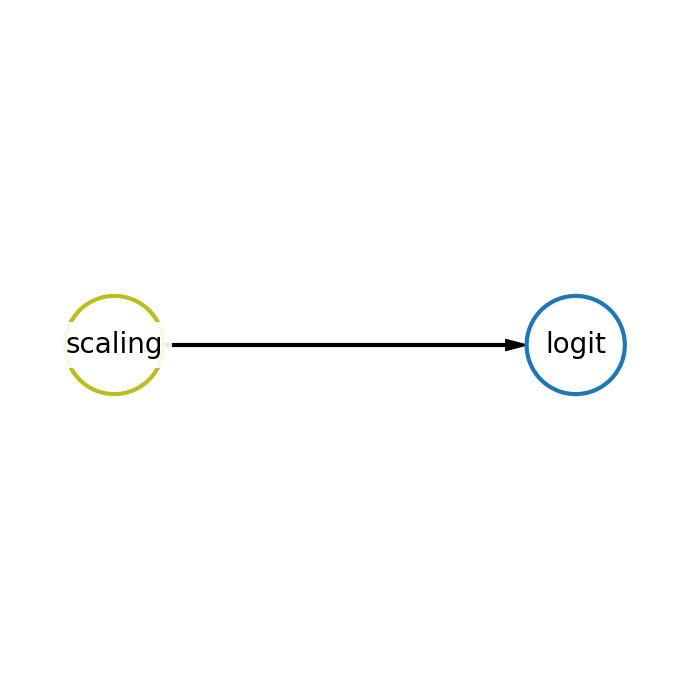

In [10]:
pipeline.show()

In [11]:
prediction = fedot_model.predict_proba(features=x_data)
print(pipeline)
print(f'ROC AUC score on training sample: {roc_auc(y_data, prediction):.3f}')

{'depth': 2, 'length': 2, 'nodes': [logit, scaling]}
ROC AUC score on training sample: 0.956


### Core-based example

We will transform the data into a specific format (InputData) for the algorithm launch.

In [17]:
import datetime
import numpy as np 

# Dataclass for wrapping arrays into it
from fedot.core.data.data import InputData

# Tasks to solve
from fedot.core.repository.tasks import Task, TaskTypesEnum

# Type of the input data
from fedot.core.repository.dataset_types import DataTypesEnum

# Repository with operations in the FEDOT
from fedot.core.repository.operation_types_repository import get_operations_for_task

# Pipeline of the FEDOT
from fedot.core.pipelines.pipeline import Pipeline

# Evolutionary algorithm classes 
from fedot.core.composer.composer_builder import ComposerBuilder
from fedot.core.composer.gp_composer.gp_composer import PipelineComposerRequirements
from golem.core.optimisers.genetic.gp_params import GPAlgorithmParameters
from golem.core.optimisers.genetic.operators.inheritance import GeneticSchemeTypesEnum
from fedot.core.repository.quality_metrics_repository import ClassificationMetricsEnum

Let's define the task that we plan to solve - classification

We will also wrap the data in a special structure-Input Data, where we will assign features, specify target, pass the data type (table) and the specified type of the task to be solved.

In [18]:
# Define classification task
task = Task(TaskTypesEnum.classification)

# Prepare data to train the model
input_data = InputData(idx=np.arange(0, len(x_data)), features=x_data,
                       target=y_data, task=task,
                       data_type=DataTypesEnum.table)

Now we have identified the data and the task within which we will look for a solution.

Next, we want to find a composite model (pipeline) of such a structure that predicts class labels as accurately as possible. We can determine from which models we can assemble such pipelines.

In [19]:
# The search of the models provided by the framework that can be used as nodes in a pipeline for the selected task
available_model_types = ['scaling', 'bernb', 'dt', 'knn', 'lda', 'logit', 'mlp', 'qda', 'rf', 'xgboost']

Let's set the metric that we will use during the evolution process, select "ROCAUC_penalty"

In [20]:
# The choice of the metric for the pipeline quality assessment during composition
metric_function = ClassificationMetricsEnum.ROCAUC_penalty

#### Composer

Composer is a genetic algorithm that allows you to search for optimal solutions by composing the pipelines of single machine learning models. 

Through PipelineComposerRequirements, we can set some hyperparameters to adjust the behavior of the evolutionary algorithm.

With the help of PipelineComposerRequirements, you can manage:
* types of models that can be inserted into primary nodes
* types of models that can be inserted into secondary nodes

* arity of directed acyclic graph (DAG)
* maximum depth of the found pipeline
* time to find a solution

In [21]:
# The choice and initialisation of the GP search
timeout = datetime.timedelta(minutes=1)
composer_requirements = PipelineComposerRequirements(
    primary=available_model_types,
    secondary=available_model_types, 
    max_arity=3,
    max_depth=3, 
    timeout=timeout,
    cv_folds=2)

Below we will define the genetic scheme of the algorithm. 

There are several schemes:
* steady_state - evolutionary scheme, also known as $(\mu+\lambda)$. New population is generated by using a selection operator which is applied to the union of the offspring and the previous population;
* generational - the offspring completely replaces the parent population;
* parameter_free - steady-state evolutionary scheme, but $\mu$ (population size) changes during evolution like the Fibonacci sequence and $\lambda$ always equals to the previous item of the sequence with respect to $\mu$.

For more information you can check [preprint](https://arxiv.org/abs/2103.01301).

We will also use the GPComposerBuilder structure, which allows you to set parameters in GPComposer.


In [25]:
from fedot.core.composer.gp_composer.specific_operators import parameter_change_mutation
from golem.core.optimisers.genetic.operators.mutation import MutationTypesEnum

INFO:root:DataSourceSplitter - K-folds cross validation is applied.


2023-03-10 18:48:40,007 - DataSourceSplitter - K-folds cross validation is applied.


Generations: 1gen [00:00, ?gen/s]INFO:root:MultiprocessingDispatcher - Number of used CPU's: 1


2023-03-10 18:48:40,012 - MultiprocessingDispatcher - Number of used CPU's: 1


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-10 18:48:51,040 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 1 size: 20


2023-03-10 18:48:51,082 - EvoGraphOptimizer - Generation num: 1 size: 20


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<ClassificationMetricsEnum.ROCAUC_penalty=-0.952 ComplexityMetricsEnum.node_num=0.400>']


2023-03-10 18:48:51,083 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<ClassificationMetricsEnum.ROCAUC_penalty=-0.952 ComplexityMetricsEnum.node_num=0.400>']


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 1


2023-03-10 18:48:51,125 - MultiprocessingDispatcher - Number of used CPU's: 1


CRITICAL:root:MultiprocessingDispatcher - 21 individuals out of 21 in previous population were evaluated successfully.


2023-03-10 18:48:52,553 - MultiprocessingDispatcher - 21 individuals out of 21 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 2 size: 21


2023-03-10 18:48:52,586 - EvoGraphOptimizer - Generation num: 2 size: 21


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<ClassificationMetricsEnum.ROCAUC_penalty=-0.952 ComplexityMetricsEnum.node_num=0.400>']


2023-03-10 18:48:52,587 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<ClassificationMetricsEnum.ROCAUC_penalty=-0.952 ComplexityMetricsEnum.node_num=0.400>']


INFO:root:EvoGraphOptimizer - no improvements for 1 iterations


2023-03-10 18:48:52,588 - EvoGraphOptimizer - no improvements for 1 iterations


INFO:root:EvoGraphOptimizer - spent time: 0.2 min


2023-03-10 18:48:52,589 - EvoGraphOptimizer - spent time: 0.2 min


INFO:root:EvoGraphOptimizer - Next population size: 34; max graph depth: 3


2023-03-10 18:48:52,591 - EvoGraphOptimizer - Next population size: 34; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 1


2023-03-10 18:48:53,164 - MultiprocessingDispatcher - Number of used CPU's: 1


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-10 18:49:04,651 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 3 size: 34


2023-03-10 18:49:04,703 - EvoGraphOptimizer - Generation num: 3 size: 34


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<ClassificationMetricsEnum.ROCAUC_penalty=-0.954 ComplexityMetricsEnum.node_num=0.100>']


2023-03-10 18:49:04,705 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<ClassificationMetricsEnum.ROCAUC_penalty=-0.954 ComplexityMetricsEnum.node_num=0.100>']


INFO:root:EvoGraphOptimizer - Next population size: 21; max graph depth: 3


2023-03-10 18:49:04,706 - EvoGraphOptimizer - Next population size: 21; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 1


2023-03-10 18:49:05,171 - MultiprocessingDispatcher - Number of used CPU's: 1


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-10 18:49:12,355 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 4 size: 21


2023-03-10 18:49:12,387 - EvoGraphOptimizer - Generation num: 4 size: 21


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<ClassificationMetricsEnum.ROCAUC_penalty=-0.954 ComplexityMetricsEnum.node_num=0.100>']


2023-03-10 18:49:12,388 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<ClassificationMetricsEnum.ROCAUC_penalty=-0.954 ComplexityMetricsEnum.node_num=0.100>']


INFO:root:EvoGraphOptimizer - no improvements for 1 iterations


2023-03-10 18:49:12,389 - EvoGraphOptimizer - no improvements for 1 iterations


INFO:root:EvoGraphOptimizer - spent time: 0.5 min


2023-03-10 18:49:12,390 - EvoGraphOptimizer - spent time: 0.5 min


INFO:root:EvoGraphOptimizer - Next population size: 34; max graph depth: 3


2023-03-10 18:49:12,391 - EvoGraphOptimizer - Next population size: 34; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 1


2023-03-10 18:49:12,728 - MultiprocessingDispatcher - Number of used CPU's: 1


CRITICAL:root:MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


2023-03-10 18:49:19,693 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 5 size: 34


2023-03-10 18:49:19,740 - EvoGraphOptimizer - Generation num: 5 size: 34


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<ClassificationMetricsEnum.ROCAUC_penalty=-0.954 ComplexityMetricsEnum.node_num=0.100>']


2023-03-10 18:49:19,742 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<ClassificationMetricsEnum.ROCAUC_penalty=-0.954 ComplexityMetricsEnum.node_num=0.100>']


INFO:root:EvoGraphOptimizer - no improvements for 2 iterations


2023-03-10 18:49:19,743 - EvoGraphOptimizer - no improvements for 2 iterations


INFO:root:EvoGraphOptimizer - spent time: 0.7 min


2023-03-10 18:49:19,744 - EvoGraphOptimizer - spent time: 0.7 min


INFO:root:EvoGraphOptimizer - Next population size: 55; max graph depth: 3


2023-03-10 18:49:19,745 - EvoGraphOptimizer - Next population size: 55; max graph depth: 3


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 1


2023-03-10 18:49:20,283 - MultiprocessingDispatcher - Number of used CPU's: 1


CRITICAL:root:MultiprocessingDispatcher - 32 individuals out of 32 in previous population were evaluated successfully.


2023-03-10 18:49:33,450 - MultiprocessingDispatcher - 32 individuals out of 32 in previous population were evaluated successfully.


INFO:root:EvoGraphOptimizer - Generation num: 6 size: 55


2023-03-10 18:49:33,525 - EvoGraphOptimizer - Generation num: 6 size: 55


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<ClassificationMetricsEnum.ROCAUC_penalty=-0.954 ComplexityMetricsEnum.node_num=0.100>']


2023-03-10 18:49:33,526 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<ClassificationMetricsEnum.ROCAUC_penalty=-0.954 ComplexityMetricsEnum.node_num=0.100>']


INFO:root:EvoGraphOptimizer - no improvements for 3 iterations


2023-03-10 18:49:33,527 - EvoGraphOptimizer - no improvements for 3 iterations


INFO:root:EvoGraphOptimizer - spent time: 0.9 min


2023-03-10 18:49:33,528 - EvoGraphOptimizer - spent time: 0.9 min


CRITICAL:root:GroupedCondition - Optimisation stopped: Time limit is reached


2023-03-10 18:49:33,529 - GroupedCondition - Optimisation stopped: Time limit is reached


Generations: 1gen [00:53, ?gen/s]
INFO:root:OptimisationTimer - Composition time: 0.892 min


2023-03-10 18:49:33,531 - OptimisationTimer - Composition time: 0.892 min


INFO:root:OptimisationTimer - Algorithm was terminated due to processing time limit


2023-03-10 18:49:33,532 - OptimisationTimer - Algorithm was terminated due to processing time limit


INFO:root:EvoGraphOptimizer - Generation num: 7 size: 1


2023-03-10 18:49:33,536 - EvoGraphOptimizer - Generation num: 7 size: 1


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<ClassificationMetricsEnum.ROCAUC_penalty=-0.954 ComplexityMetricsEnum.node_num=0.100>']


2023-03-10 18:49:33,537 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<ClassificationMetricsEnum.ROCAUC_penalty=-0.954 ComplexityMetricsEnum.node_num=0.100>']


INFO:root:EvoGraphOptimizer - no improvements for 4 iterations


2023-03-10 18:49:33,538 - EvoGraphOptimizer - no improvements for 4 iterations


INFO:root:EvoGraphOptimizer - spent time: 0.9 min


2023-03-10 18:49:33,539 - EvoGraphOptimizer - spent time: 0.9 min


INFO:root:GPComposer - GP composition finished


2023-03-10 18:49:33,541 - GPComposer - GP composition finished


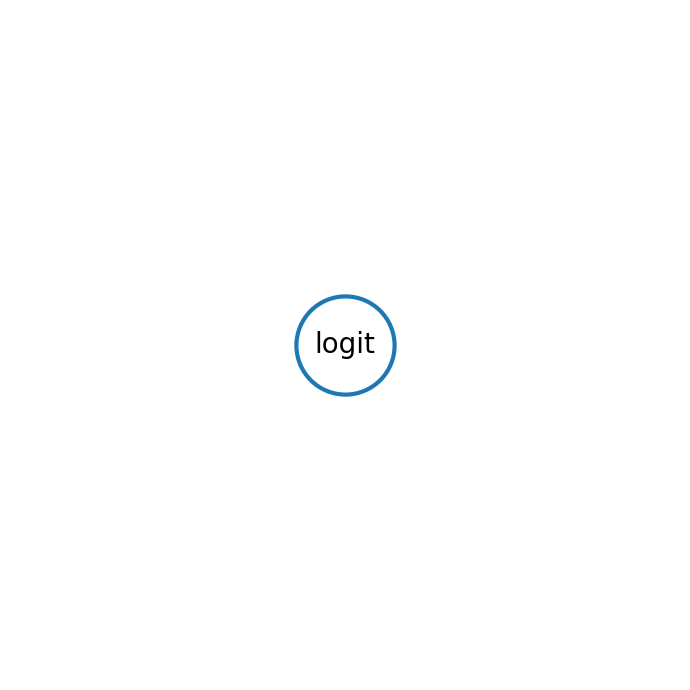

In [27]:
# GP optimiser parameters choice
scheme_type = GeneticSchemeTypesEnum.parameter_free
mutation_types = [parameter_change_mutation, MutationTypesEnum.growth, MutationTypesEnum.reduce, MutationTypesEnum.simple]
graph_opt_params = GPAlgorithmParameters(
    genetic_scheme_type=scheme_type,
    mutation_types=mutation_types,
    crossover_prob=0.8,
    mutation_prob=0.8)

# Create builder for composer and set composer params
builder = ComposerBuilder(task=task).\
    with_requirements(composer_requirements).\
    with_optimizer_params(graph_opt_params).\
    with_metrics(metric_function)

# Create GP-based composer
composer = builder.build()

# the optimal pipeline generation by composition - the most time-consuming task
pipeline_evo_composed = composer.compose_pipeline(data=input_data)
pipeline_evo_composed.show()

We got a pipeline of several machine learning models. But in the course of evolution, the hyperparameters of these models did not change. Now, within the given topology, we will optimize the hyperparameters.

In [29]:
from fedot.core.pipelines.tuning.tuner_builder import TunerBuilder
from golem.core.tuning.simultaneous import SimultaneousTuner
from fedot.core.repository.quality_metrics_repository import  ClassificationMetricsEnum


tuner = TunerBuilder(input_data.task)\
        .with_tuner(SimultaneousTuner)\
        .with_metric(ClassificationMetricsEnum.ROCAUC)\
        .with_iterations(20) \
        .build(input_data)
tuned_pipeline = tuner.tune(pipeline_evo_composed)

#final fit on all data
tuned_pipeline.fit(input_data)
print('Pipeline tuned')

INFO:root:DataSourceSplitter - Hold out validation is applied.


2023-03-10 18:51:52,373 - DataSourceSplitter - Hold out validation is applied.


INFO:root:SimultaneousTuner - Hyperparameters optimization start: estimation of metric for initial pipeline


2023-03-10 18:51:52,376 - SimultaneousTuner - Hyperparameters optimization start: estimation of metric for initial pipeline


CRITICAL:root:SimultaneousTuner - Initial graph: {'depth': 1, 'length': 1, 'nodes': [logit]}
logit - {} 
Initial metric: 0.966


2023-03-10 18:51:52,388 - SimultaneousTuner - Initial graph: {'depth': 1, 'length': 1, 'nodes': [logit]}
logit - {} 
Initial metric: 0.966
  0%|                                                                           | 0/20 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds


2023-03-10 18:51:52,392 - build_posterior_wrapper took 0.000000 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2023-03-10 18:51:52,393 - TPE using 0 trials


INFO:hyperopt.tpe:build_posterior_wrapper took 0.000995 seconds


2023-03-10 18:51:52,407 - build_posterior_wrapper took 0.000995 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss -0.966000


2023-03-10 18:51:52,408 - TPE using 1/1 trials with best loss -0.966000


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001009 seconds


2023-03-10 18:51:52,421 - build_posterior_wrapper took 0.001009 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss -0.966000


2023-03-10 18:51:52,422 - TPE using 2/2 trials with best loss -0.966000


INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds


2023-03-10 18:51:52,433 - build_posterior_wrapper took 0.000000 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss -0.966000


2023-03-10 18:51:52,434 - TPE using 3/3 trials with best loss -0.966000


INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds


2023-03-10 18:51:52,445 - build_posterior_wrapper took 0.000000 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss -0.966000


2023-03-10 18:51:52,447 - TPE using 4/4 trials with best loss -0.966000


INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds


2023-03-10 18:51:52,459 - build_posterior_wrapper took 0.000000 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss -0.966000


2023-03-10 18:51:52,460 - TPE using 5/5 trials with best loss -0.966000


INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds


2023-03-10 18:51:52,471 - build_posterior_wrapper took 0.000000 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss -0.966000


2023-03-10 18:51:52,473 - TPE using 6/6 trials with best loss -0.966000


INFO:hyperopt.tpe:build_posterior_wrapper took 0.000999 seconds


2023-03-10 18:51:52,486 - build_posterior_wrapper took 0.000999 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss -0.966000


2023-03-10 18:51:52,487 - TPE using 7/7 trials with best loss -0.966000
 40%|████████████████████████▍                                    | 8/20 [00:00<00:00, 74.22trial/s, best loss: -0.966]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds


2023-03-10 18:51:52,500 - build_posterior_wrapper took 0.000000 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss -0.966000


2023-03-10 18:51:52,502 - TPE using 8/8 trials with best loss -0.966000


INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds


2023-03-10 18:51:52,514 - build_posterior_wrapper took 0.000000 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss -0.966000


2023-03-10 18:51:52,516 - TPE using 9/9 trials with best loss -0.966000


INFO:hyperopt.tpe:build_posterior_wrapper took 0.001002 seconds


2023-03-10 18:51:52,528 - build_posterior_wrapper took 0.001002 seconds


INFO:hyperopt.tpe:TPE using 10/10 trials with best loss -0.966000


2023-03-10 18:51:52,530 - TPE using 10/10 trials with best loss -0.966000


INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds


2023-03-10 18:51:52,541 - build_posterior_wrapper took 0.000000 seconds


INFO:hyperopt.tpe:TPE using 11/11 trials with best loss -0.966000


2023-03-10 18:51:52,543 - TPE using 11/11 trials with best loss -0.966000


INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds


2023-03-10 18:51:52,556 - build_posterior_wrapper took 0.000000 seconds


INFO:hyperopt.tpe:TPE using 12/12 trials with best loss -0.966000


2023-03-10 18:51:52,558 - TPE using 12/12 trials with best loss -0.966000


INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds


2023-03-10 18:51:52,570 - build_posterior_wrapper took 0.000000 seconds


INFO:hyperopt.tpe:TPE using 13/13 trials with best loss -0.966000


2023-03-10 18:51:52,573 - TPE using 13/13 trials with best loss -0.966000


INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds


2023-03-10 18:51:52,584 - build_posterior_wrapper took 0.000000 seconds


INFO:hyperopt.tpe:TPE using 14/14 trials with best loss -0.966000


2023-03-10 18:51:52,586 - TPE using 14/14 trials with best loss -0.966000


INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds


2023-03-10 18:51:52,598 - build_posterior_wrapper took 0.000000 seconds


INFO:hyperopt.tpe:TPE using 15/15 trials with best loss -0.966000


2023-03-10 18:51:52,600 - TPE using 15/15 trials with best loss -0.966000
 80%|████████████████████████████████████████████████            | 16/20 [00:00<00:00, 72.54trial/s, best loss: -0.966]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds


2023-03-10 18:51:52,612 - build_posterior_wrapper took 0.000000 seconds


INFO:hyperopt.tpe:TPE using 16/16 trials with best loss -0.966000


2023-03-10 18:51:52,614 - TPE using 16/16 trials with best loss -0.966000


INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds


2023-03-10 18:51:52,625 - build_posterior_wrapper took 0.000000 seconds


INFO:hyperopt.tpe:TPE using 17/17 trials with best loss -0.966000


2023-03-10 18:51:52,627 - TPE using 17/17 trials with best loss -0.966000


INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds


2023-03-10 18:51:52,638 - build_posterior_wrapper took 0.000000 seconds


INFO:hyperopt.tpe:TPE using 18/18 trials with best loss -0.966000


2023-03-10 18:51:52,640 - TPE using 18/18 trials with best loss -0.966000


INFO:hyperopt.tpe:build_posterior_wrapper took 0.000999 seconds


2023-03-10 18:51:52,651 - build_posterior_wrapper took 0.000999 seconds


INFO:hyperopt.tpe:TPE using 19/19 trials with best loss -0.966000


2023-03-10 18:51:52,653 - TPE using 19/19 trials with best loss -0.966000
100%|████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 73.30trial/s, best loss: -0.966]

INFO:root:SimultaneousTuner - Hyperparameters optimization finished



2023-03-10 18:51:52,675 - SimultaneousTuner - Hyperparameters optimization finished


INFO:root:SimultaneousTuner - Return init graph due to the fact that obtained metric 0.966 worse than initial (+ 0.05% deviation) 0.966


2023-03-10 18:51:52,676 - SimultaneousTuner - Return init graph due to the fact that obtained metric 0.966 worse than initial (+ 0.05% deviation) 0.966


CRITICAL:root:SimultaneousTuner - Final graph: {'depth': 1, 'length': 1, 'nodes': [logit]}
logit - {}


2023-03-10 18:51:52,678 - SimultaneousTuner - Final graph: {'depth': 1, 'length': 1, 'nodes': [logit]}
logit - {}


CRITICAL:root:SimultaneousTuner - Final metric: 0.966


2023-03-10 18:51:52,680 - SimultaneousTuner - Final metric: 0.966
Pipeline tuned


Check the metric

In [34]:
prediction = tuned_pipeline.predict(input_data)
print(f'ROC AUC score on training sample: {roc_auc(input_data.target, prediction.predict):.3f}')

ROC AUC score on training sample: 0.956


As you can see from the metric value, the model was well trained on the training sample. 

### Pipeline visualistion 

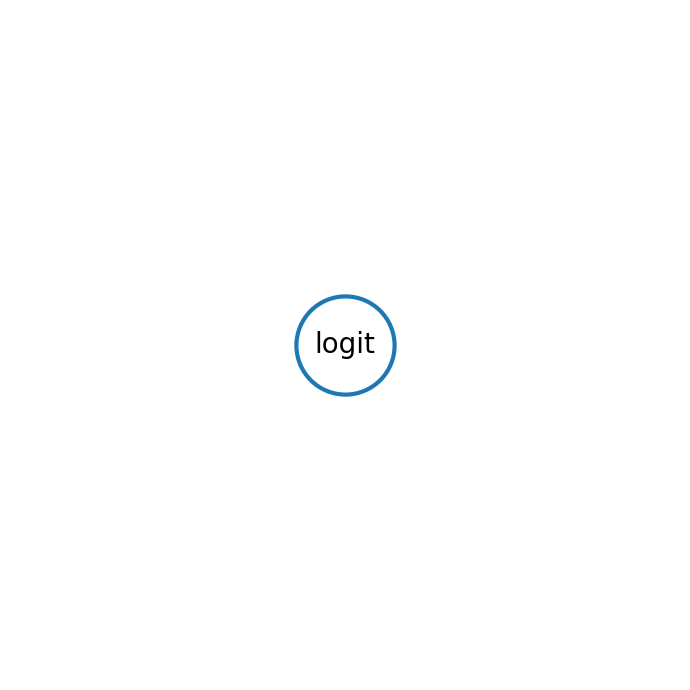

In [31]:
tuned_pipeline.show()

So, in this notebook, you learned how to run FEDOT for the classification task, both using the API and using more complex constructs from the core based on the functionality of the FEDOT framework.